In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

email_data = pd.read_csv('/content/drive/MyDrive/FYPDataset/cleaned_email_data.csv')

Mounted at /content/drive


In [ ]:
if 'Combined_Text' in email_data.columns:
    print("The 'Combined_Text' column exists in the DataFrame.")

    nan_or_empty_count = email_data['Combined_Text'].isna().sum() + (email_data['Combined_Text'] == '').sum()

    if nan_or_empty_count == 0:
        print("No NaN or empty string values in 'Combined_Text'.")
    else:
        print(f"There are {nan_or_empty_count} NaN or empty string values in 'Combined_Text'.")
else:
    print("The 'Combined_Text' column does not exist in the DataFrame.")

The 'Combined_Text' column exists in the DataFrame.
No NaN or empty string values in 'Combined_Text'.


In [ ]:
email_data.columns

Index(['From', 'To', 'Subject', 'Message', 'Day', 'Date & Time',
       'Response Time', 'Extracted Metadata', 'url_count',
       'email_address_count', 'attachment_count', 'Cleaned_Subject',
       'Cleaned_Message', 'Combined_Text'],
      dtype='object')

In [ ]:
email_data = email_data.drop(columns=["Day"])
email_data = email_data.drop(columns=["Date & Time"])
email_data = email_data.drop(columns=["Response Time"])
email_data = email_data.drop(columns=["Extracted Metadata"])

In [ ]:
email_data.columns

Index(['From', 'To', 'Subject', 'Message', 'url_count', 'email_address_count',
       'attachment_count', 'Cleaned_Subject', 'Cleaned_Message',
       'Combined_Text'],
      dtype='object')

In [ ]:
#from google.colab import files
# Extract exactly 10,000 rows (random sample)
#email_sample = email_data.sample(n=10000, random_state=42)

# Save the sampled dataset as a CSV file
#email_sample.to_csv('email_sample.csv', index=False)

# Download the file
#files.download('email_sample.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
email_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248819 entries, 0 to 248818
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   From                 248819 non-null  object
 1   To                   239115 non-null  object
 2   Subject              241381 non-null  object
 3   Message              248818 non-null  object
 4   url_count            248819 non-null  int64 
 5   email_address_count  248819 non-null  int64 
 6   attachment_count     248819 non-null  int64 
 7   Cleaned_Subject      231831 non-null  object
 8   Cleaned_Message      248201 non-null  object
 9   Combined_Text        248819 non-null  object
dtypes: int64(3), object(7)
memory usage: 19.0+ MB


#Ollama

In [ ]:
!pip install pandas requests tqdm

In [ ]:
import requests

def label_email_llama3(email_text):
    prompt = f"""Categorize the following email into exactly one of these categories:

- Spam
- Promotion
- Newsletter
- Business Communication
- General Discussion & Internal Updates
- IT Alerts & System Notifications

Email: "{email_text}"

Category:"""

    response = requests.post(
        'http://localhost:11434/api/generate',
        json={
            'model': 'llama3',
            'prompt': prompt,
            'stream': False,
            'temperature': 0.1,
            'max_tokens': 15
        }
    ).json()

    return response['response'].strip()

# Test single labeling:
print(label_email_llama3("Limited offer, subscribe now and save!"))

In [ ]:
import pandas as pd
import requests
from tqdm import tqdm

# Function to get labels from Llama3 via Ollama
def label_email_llama3(email_text):
    prompt = f"""Categorize the following email into exactly one of these categories:

- Spam
- Promotion
- Newsletter
- Business Communication
- General Discussion & Internal Updates
- IT Alerts & System Notifications

Email: "{email_text}"

Category:"""

    response = requests.post(
        'http://localhost:11434/api/generate',
        json={
            'model': 'llama3',
            'prompt': prompt,
            'stream': False,
            'temperature': 0.1,
            'max_tokens': 15
        }
    ).json()

    return response['response'].strip()

# Apply labeling to your dataset
tqdm.pandas(desc="Labeling Emails")
email_data['Ollama_Category'] = email_data['Combined_Text'].progress_apply(label_email_llama3)

In [ ]:
# Save labeled data
email_data.to_csv('email_data_labeled.csv', index=False)

#Non-Negative Matrix Factorization

In [ ]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Robust TF-IDF vectorization (critical step)
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.75,
    min_df=3,
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)
X = vectorizer.fit_transform(email_data['Combined_Text'])

nmf_model = NMF(n_components=9, random_state=42, max_iter=1000, init='nndsvd')
nmf_features = nmf_model.fit_transform(X)

email_data['Topic'] = nmf_features.argmax(axis=1)

# Check topics again:
terms = vectorizer.get_feature_names_out()
for index, topic in enumerate(nmf_model.components_):
    print(f"\nTopic {index}:")
    print(", ".join([terms[i] for i in topic.argsort()[:-15 - 1:-1]]))

# AFTER reviewing printed top words for each topic, manually map topics correctly:
# Example (adjust according to actual output):
category_labels = {
    0: 'General Discussion & Internal Updates',
    1: 'IT Alerts & System Notifications',
    2: 'Legal & Contractual',
    3: 'Legal & Contractual',
    4: 'Spam',
    5: 'Finance & Transaction',
    6: 'Meeting & Scheduling',
    7: 'Legal & Contractual',
    8: 'IT Alerts & System Notifications'
}

def assign_category(row):
    if len(row['Combined_Text'].split()) <= 5:
        return 'General Discussion & Internal Updates'
    else:
        return category_labels[row['Topic']]

email_data['NMF_Category'] = email_data.apply(assign_category, axis=1)

email_data['NMF_Category'].value_counts()

In [ ]:
random_samples = email_data[['Subject', 'Combined_Text', 'NMF_Category']].sample(n=100)

for index, row in random_samples.iterrows():
    if str(row['NMF_Category']).strip() == 'Spam':
        print(f"Subject: {row['Subject']}")
        print(f"Message: {row['Combined_Text']}")
        print(f"NMF_Category: {row['NMF_Category']}")
        print("-" * 20)

Subject: NGL Players
Message: ngl player abetter list large player ngl markets
NMF_Category: Spam
--------------------
Subject: Re: Cargill Energy, a division of Cargill Incorporated
Message: cargill energy division cargill incorporated info
NMF_Category: Spam
--------------------
Subject: Mideast Crisis
Message: mideast crisis print mideast crisis
NMF_Category: Spam
--------------------


In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords

# Downloads
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Corrected preprocessing (no punkt tokenizer needed)
def preprocess(text):
    tokens = [word.lower() for word in text.split() if word.isalpha() and word.lower() not in stop_words]
    return tokens

email_data['tokens'] = email_data['Combined_Text'].apply(preprocess)

# Prepare TaggedDocuments
tagged_docs = [
    TaggedDocument(words=row, tags=[i])
    for i, row in enumerate(email_data['tokens'])
]

# Doc2Vec Model
model = Doc2Vec(vector_size=100, window=5, min_count=2, epochs=40, workers=4, dm=1, seed=42)
model.build_vocab(tagged_docs)
model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)

# Extract vectors for each document
email_data['doc_vector'] = [model.dv[i] for i in range(len(email_data))]

# Categorize using KMeans
kmeans = KMeans(n_clusters=7, random_state=42)
email_data['Doc2Vec_Category'] = kmeans.fit_predict(list(email_data['doc_vector']))

# Display categorization results
print(email_data[['Combined_Text', 'Doc2Vec_Category']].head(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                       Combined_Text  Doc2Vec_Category
0  oati etag minimum requirement time run short c...                 1
1  oati etag minimum requirement time run short c...                 1
2  oati etag minimum requirement time run short c...                 1
3  oati etag minimum requirement time run short c...                 1
4  gonescr virus warning immediately delete open ...                 4
5  gonescr virus warning immediately delete open ...                 4
6  henwoods rationalizing midwest power market fu...                 1
7  best company survey enron innovative company a...                 1
8  year energy abc channel proud announce enron t...                 1
9  announcing market virtually untapped like lear...                 4


In [ ]:
#Download File for Backup
from google.colab import files

email_data.to_csv("email_data_Doc2Vec_category.csv", index=False)
files.download('email_data_Doc2Vec_category.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#URL_ANALYSIS

In [ ]:
max_url_count = email_data['url_count'].max()
print("Highest URL Count:", max_url_count)

Highest URL Count: 269


url_count
1     18507
2      4954
3      2352
4      1324
5       809
6       590
7       491
8       489
9       391
10      331
Name: count, dtype: int64


<ipython-input-3-66b1dd460c4b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts_0_50.index, y=top_counts_0_50.values, palette="viridis")


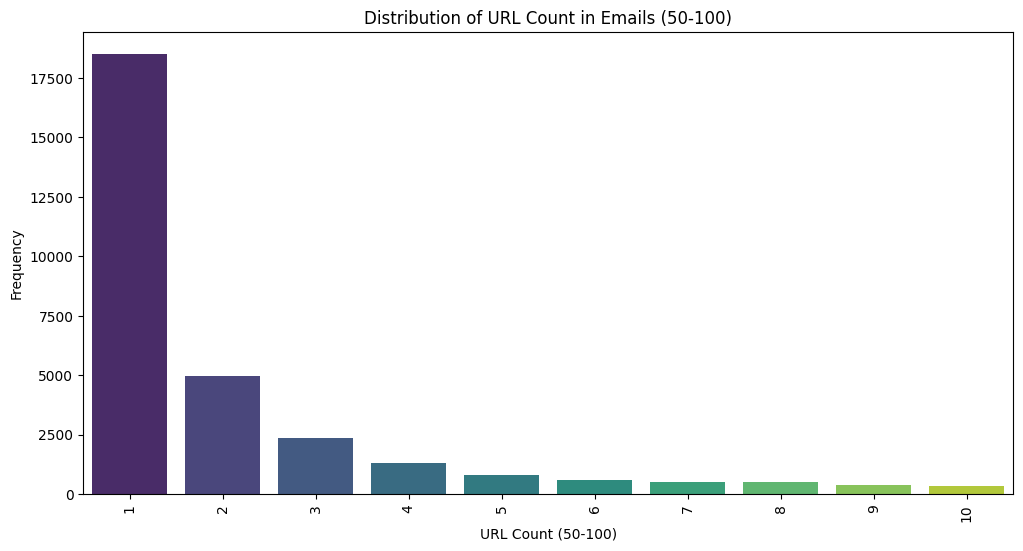

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
url_count_filtered = email_data[email_data['url_count'].between(1, 10)]
top_counts_0_50 = url_count_filtered['url_count'].value_counts().sort_index()
print(top_counts_0_50)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_counts_0_50.index, y=top_counts_0_50.values, palette="viridis")
plt.xlabel("URL Count (50-100)")
plt.ylabel("Frequency")
plt.title("Distribution of URL Count in Emails (50-100)")
plt.xticks(rotation=90)
plt.show()

url_count
100    1
102    1
103    1
104    7
105    2
      ..
235    1
245    1
247    1
250    1
269    1
Name: count, Length: 61, dtype: int64


<ipython-input-4-775a5ce8de78>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts_0_50.index, y=top_counts_0_50.values, palette="viridis")


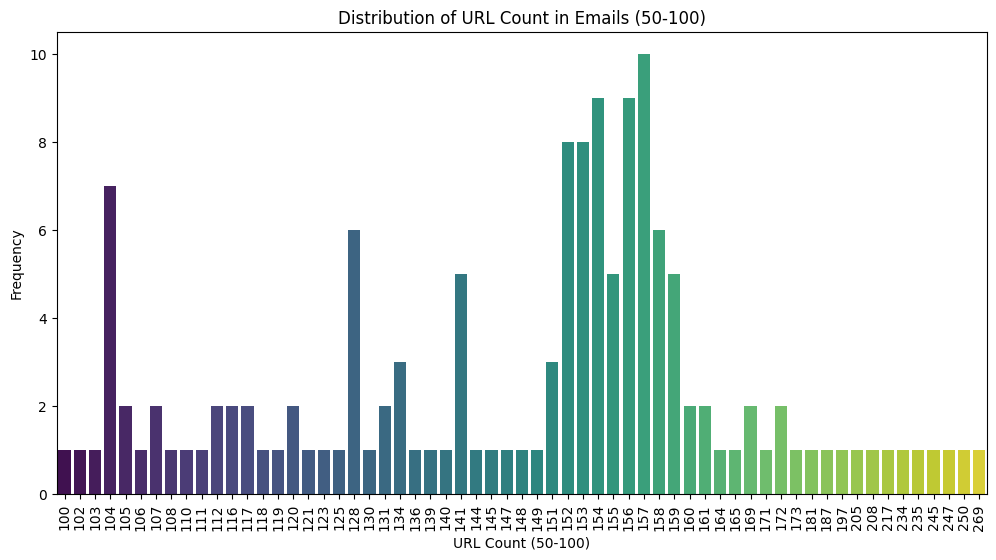

In [ ]:
url_count_filtered = email_data[email_data['url_count'].between(100, 269)]
top_counts_0_50 = url_count_filtered['url_count'].value_counts().sort_index()
print(top_counts_0_50)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_counts_0_50.index, y=top_counts_0_50.values, palette="viridis")
plt.xlabel("URL Count (50-100)")
plt.ylabel("Frequency")
plt.title("Distribution of URL Count in Emails (50-100)")
plt.xticks(rotation=90)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

#TOPIC MODELING - 10 URL_COUNT to 269 URL_COUNT - LIKELY SPAM/PROMOTION/NEWSLETTER

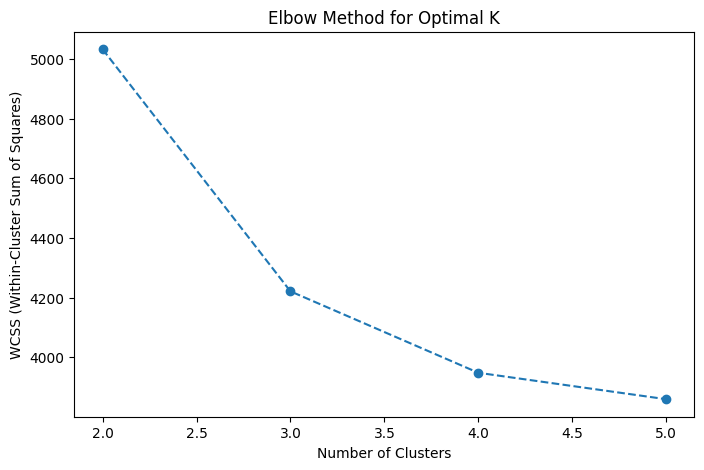

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Filtering dataset for URL count between 10 and 269
filtered_data = email_data[(email_data['url_count'] >= 10) & (email_data['url_count'] <= 269)].copy()

vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
tfidf_matrix = vectorizer.fit_transform(filtered_data['Combined_Text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Standardizing URL count
scaler = StandardScaler()
filtered_data['url_count_scaled'] = scaler.fit_transform(filtered_data[['url_count']])

# Combine URL count with TF-IDF matrix for clustering
clustering_data = pd.concat([filtered_data[['url_count_scaled']].reset_index(drop=True), tfidf_df], axis=1)

# Determining optimal clusters using Elbow Method
wcss = []
k_range = range(2, 6)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

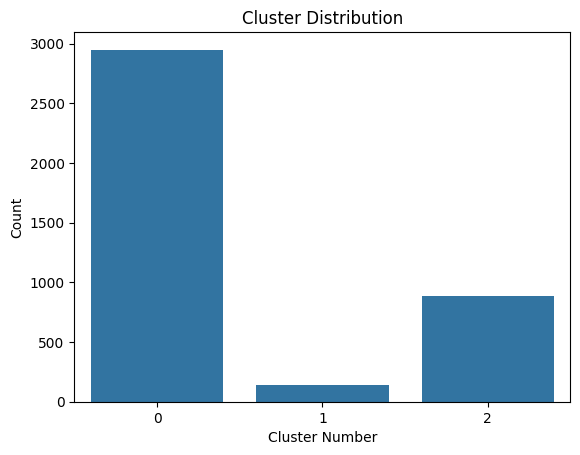

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
filtered_data['Cluster'] = kmeans.fit_predict(clustering_data)

sns.countplot(x=filtered_data['Cluster'])
plt.title("Cluster Distribution")
plt.xlabel("Cluster Number")
plt.ylabel("Count")
plt.show()

In [ ]:
def get_top_keywords(tfidf_matrix, clusters, vectorizer, n_terms=150):
    df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df['Cluster'] = clusters
    top_keywords = {}
    for cluster in sorted(df['Cluster'].unique()):
        cluster_keywords = df[df['Cluster'] == cluster].drop(columns=['Cluster']).mean().sort_values(ascending=False)[:n_terms]
        top_keywords[cluster] = cluster_keywords.index.tolist()
    return top_keywords

top_keywords = get_top_keywords(tfidf_matrix, filtered_data['Cluster'], vectorizer)
for cluster, keywords in top_keywords.items():
    print(f"Cluster {cluster}: {', '.join(keywords)}")

Cluster nan: ability, able, accept, access, accessory, accord, account, accounting, accurate, acquire, acquisition, act, action, active, activity, actually, add, addition, additional, address, administration, adult, advance, advanced, advantage, adventure, advertise, advertisement, advertiser, advertising, advice, aeco, affect, affiliate, afghan, afghanistan, africa, age, agency, agent, ago, agree, agreement, agua, ahead, aid, aim, air, airfare, airline, airlines, airport, airways, al, alamo, alan, alaska, albany, albuquerque, alert, alliance, allow, alternative, amarillo, amazon, america, american, americans, ameritrade, amsterdam, analysis, analyst, andrew, anew, angeles, announce, announcement, annual, anr, answer, anthrax, anti, antonio, anytime, aol, app, appeal, appear, apple, applicable, application, apply, approach, appropriate, approval, approve, approximately, apr, april, archive, army, arrive, art, arthur, article, asia, asian, ask, asp, asset, assistance, associate, associa

In [ ]:
print("Missing cluster assignments:", filtered_data['Cluster'].isna().sum())

print(filtered_data[filtered_data['Cluster'].isna()])


Missing cluster assignments: 0
Empty DataFrame
Columns: [From, To, Subject, Message, url_count, email_address_count, attachment_count, Cleaned_Subject, Cleaned_Message, Combined_Text, url_count_scaled, Cluster]
Index: []


In [ ]:
cluster_to_category = {
    0.0: "Promotion",
    2.0: "Spam",
    1.0: "Newsletter"  # NaN is considered as informational emails
}

filtered_data['Category'] = filtered_data['Cluster'].map(cluster_to_category)

In [ ]:
filtered_data['Category'].value_counts()

,count
Category,
Promotion,2950
Spam,889
Newsletter,142


In [ ]:
import pandas as pd

random_samples = filtered_data[['Subject', 'Combined_Text', 'Category']].sample(n=10)

# Print results
for index, row in random_samples.iterrows():
    print(f"Subject: {row['Subject']}")
    print(f"Message: {row['Combined_Text'][:300]}...")
    print(f"Category: {row['Category']}")
    print("-" * 100)


In [ ]:
import pandas as pd
import numpy as np

# 🔹 Expanded Keyword Lists for More Accurate Categorization

# Spam Keywords
spam_keywords = {
    "unsubscribe", "click", "remove", "winner", "money", "free", "offer", "discount", "buy", "win", "lottery",
    "investment", "cash", "urgent", "limited", "claim", "credit", "debt", "pay", "order", "subscribe", "special",
    "exclusive", "access", "funds", "bonus", "earn", "fast", "prize", "lottery", "best deal", "crypto", "profit",
    "loan", "finance", "broker", "fundraising", "earn money", "instant cash", "sweepstakes", "guaranteed", "no risk",
    "investment opportunity", "act now", "winning", "one time offer", "increase income", "forex", "binary trading",
    "loan approval", "cash back", "insurance", "refinance", "pills", "medicine", "zero cost", "credit card offer",
    "debt relief", "home refinance", "miracle cure", "fast approval", "best investment", "quick money", "guaranteed income",
    "limited offer", "get rich", "investment scam", "pyramid scheme", "credit repair", "work from home", "business opportunity",
    "financial freedom", "quick loans", "no interest loans", "easy money", "unsecured credit", "get paid", "cash advance",
    "debt consolidation", "no credit check", "credit card debt", "bill consolidation", "payday loan",
    # Added explicit, violent, and drug-related terms
    "fuck", "shit", "bitch", "ass", "dick", "pussy", "cock", "slut", "whore", "motherfucker", "damn", "cunt",
    "bastard", "fucker", "prick", "sex", "porn", "pornography", "adult", "escort", "hooker", "sex toys", "xxx",
    "nude", "nudity", "orgy", "masturbate", "erotic", "adult content", "fetish", "sexting", "porn star", "hookup",
    "rape", "assault", "bullying", "abuse", "violence", "fight", "killer", "death threat", "murder", "shoot", "stabbing",
    "beating", "choking", "weed", "marijuana", "cocaine", "crack", "meth", "heroin", "drug", "high", "stoned", "trip",
    "dope", "joint", "bong", "acid", "psychedelic"
}

# Promotion Keywords
promotion_keywords = {
    "sale", "discount", "deal", "special", "offer", "promotion", "buy", "purchase", "limited time", "hot deal",
    "best price", "exclusive", "shopping", "event", "store", "low price", "brand", "new", "gift", "shipping", "save",
    "vip", "bundle", "flash sale", "clearance", "coupon", "bargain", "fare", "flight deal", "watcher", "hotel", "reward",
    "membership", "exclusive deal", "loyalty program", "vacation", "ticket", "booking", "package", "airfare", "redeem",
    "special fares", "reward points", "limited seats", "weekend special", "trip deal", "promotion code", "online shopping",
    "gift card", "price drop", "subscribe & save", "free shipping", "amazon deal", "order now", "discounted rates",
    "event ticket", "vip pass", "luxury package", "resort", "fine dining", "exclusive getaway", "private retreat", "dream vacation",
    "romantic getaway", "high end", "travel deals", "expensive gift", "chateau", "gourmet", "private island", "luxury experience",
    "five star", "premium offer", "hotels & resorts", "beauty discount", "electronics sale", "home essentials", "biggest sale",
    "redeem now", "best travel deals", "free trial", "free gift", "exclusive discount", "mega sale", "holiday sale"
}

# Newsletter Keywords
newsletter_keywords = {
    "newsletter", "headlines", "daily update", "weekly update", "monthly summary", "bulletin", "news report", "reader picks",
    "financial summary", "market summary", "sports newsletter", "energy bulletin", "subscription", "insight", "report",
    "analysis", "research", "forecast", "trend", "editorial", "industry news", "business review", "economy", "weekly digest",
    "newswire", "newsflash", "morning update", "industry update", "daily digest", "market trends", "diabetes news",
    "financial update", "policy report", "economic outlook", "technology news", "trade news", "business insight", "energy news",
    "stock report", "government update", "news update", "press release", "market insight", "corporate news", "industry trends",
    "expert analysis", "headline report", "top stories", "exclusive news", "conference report", "financial briefing",
    "investment research", "venturewire", "bna report", "business summary", "power market report", "security advisory", "threat report",
    "energy crisis", "market conditions", "technology briefing", "latest headlines", "daily power report", "enews",
    "monthly digest", "economic update", "politics report", "business forecast", "government policy", "stock update", "industry insights", "ai trends"
    "daily power report", "ibms latest linux server", "avalon northwest wine news", "onpolitics daily report", "yahoo newsletter",
    "powermarketerscom daily power report", "weekly newsletter", "eren network news", "newsbeatdaily news"
}

def assign_category(text):
    words = set(text.lower().split())

    spam_score = sum(2 for word in words if word in spam_keywords)
    promo_score = sum(1.5 for word in words if word in promotion_keywords)
    news_score = sum(2 for word in words if word in newsletter_keywords)  # Higher weight for newsletters

    if spam_score > max(promo_score, news_score):
        return "Spam"
    elif promo_score > max(spam_score, news_score):
        return "Promotion"
    elif news_score > max(spam_score, promo_score):
        return "Newsletter"

    return "Newsletter"

filtered_data["Keyword_Category"] = filtered_data["Combined_Text"].apply(assign_category)

print(filtered_data["Keyword_Category"].value_counts())

Keyword_Category
Spam          2800
Promotion      862
Newsletter     319
Name: count, dtype: int64


In [ ]:
random_samples = filtered_data[['Subject', 'Combined_Text', 'Keyword_Category']].sample(n=100)

for index, row in random_samples.iterrows():
    if str(row['Keyword_Category']).strip() == 'Unknown':
        print(f"Subject: {row['Subject']}")
        print(f"Message: {row['Combined_Text']}")
        print(f"Keyword Category: {row['Keyword_Category']}")
        print("-" * 20)

Subject: Save up to 20% on Houston's Favorites
Message: save houston favorite dear amazon com customer resident great houston like cool sneak peek read listen watch unique page feature item buy plus saving handpicke title special local interest explore thing town mean fodor cityguide singalong songs wish write texans pat green cory morrow revisit famous quote film apollo dvd season get start checkout favorite book music movie community click mark purcell team member snowbird houstonian ps interested sell suburb hometown college workplace purchase circles hundred locale organization us world hope enjoy receive message future email sort visit account settings update communication preference note send following address
Keyword Category: Unknown
--------------------
Subject: JoC ONLINE: Mineta: US needs transport security agency
Message: joc online mineta u need transport security agency joc online daily email newsletter thursday edition october national independence day azerbaijan com qui

In [ ]:
print(filtered_data["Keyword_Category"].value_counts())

Keyword_Category
Spam          2800
Promotion      862
Newsletter     319
Name: count, dtype: int64


In [ ]:
from google.colab import files

filtered_data.to_csv("filtered_data_spam_promotion_news_category_10_269.csv", index=False)
files.download('filtered_data_spam_promotion_news_category_10_269.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#TOPIC MODELING - 0 URL_COUNT to 9 URL_COUNT -

url_count
0    214931
1     18507
2      4954
3      2352
4      1324
5       809
6       590
7       491
8       489
9       391
Name: count, dtype: int64


<ipython-input-4-042b0684a3ad>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts_0_50.index, y=top_counts_0_50.values, palette="viridis")


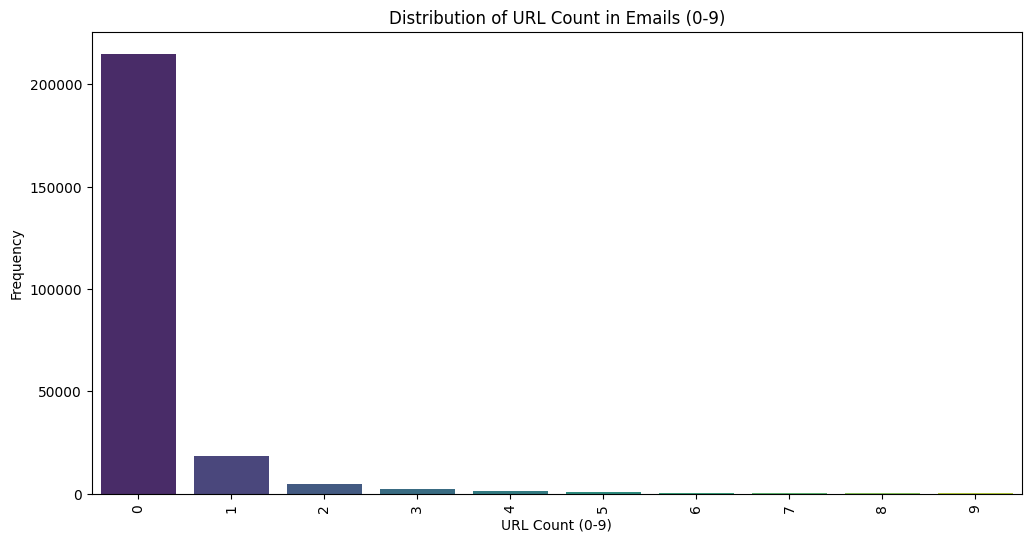

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
url_count_filtered = email_data[email_data['url_count'].between(0, 9)]
top_counts_0_50 = url_count_filtered['url_count'].value_counts().sort_index()
print(top_counts_0_50)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_counts_0_50.index, y=top_counts_0_50.values, palette="viridis")
plt.xlabel("URL Count (0-9)")
plt.ylabel("Frequency")
plt.title("Distribution of URL Count in Emails (0-9)")
plt.xticks(rotation=90)
plt.show()

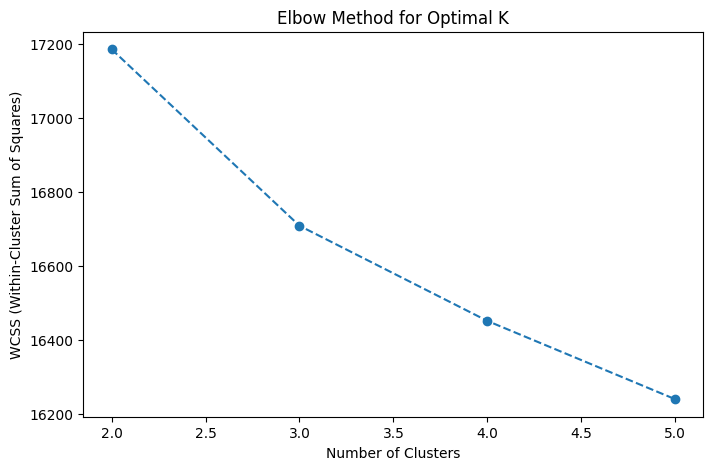

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

filtered_data = email_data[(email_data['url_count'] == 1) & (email_data['url_count'] <= 9)].copy()

vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
tfidf_matrix = vectorizer.fit_transform(filtered_data['Combined_Text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

scaler = StandardScaler()
filtered_data['url_count_scaled'] = scaler.fit_transform(filtered_data[['url_count']])

clustering_data = pd.concat([filtered_data[['url_count_scaled']].reset_index(drop=True), tfidf_df], axis=1)

wcss = []
k_range = range(2, 6)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

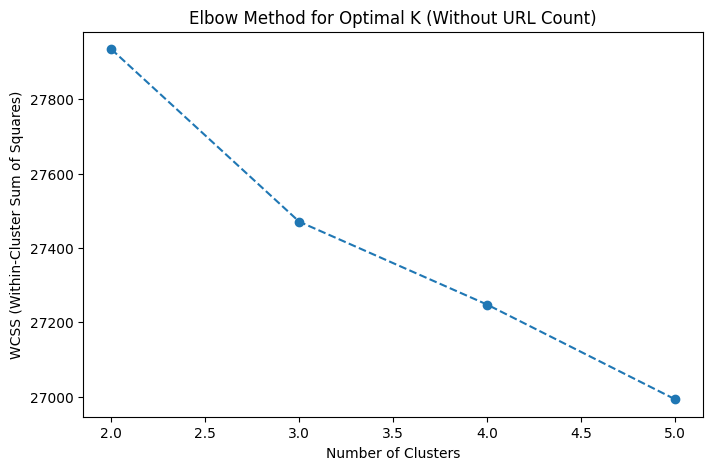

In [ ]:
clustering_data_without_url = tfidf_df
wcss_without_url = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_data_without_url)
    wcss_without_url.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, wcss_without_url, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K (Without URL Count)')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(clustering_data)
print(kmeans.cluster_centers_)

[[ 3.06172270e+00  9.58832113e-04  3.49756483e-03 ...  9.47342778e-03
   2.51351438e-03  1.37763830e-03]
 [-4.38670288e-01  1.46903637e-03  2.19711234e-03 ...  5.09478524e-03
   1.87558567e-03  1.23549451e-03]
 [ 9.55987830e-01  2.24006001e-03  2.63239001e-03 ...  8.02366677e-03
   2.58977871e-03  8.49326014e-04]]


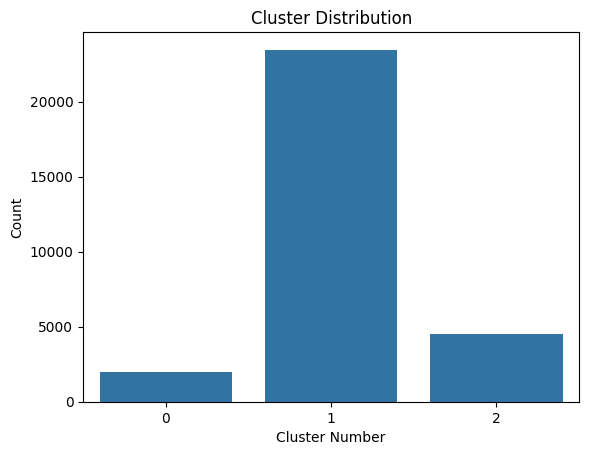

In [ ]:
# Applying K-Means with chosen K (let's assume 3 based on elbow method)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
filtered_data['Cluster'] = kmeans.fit_predict(clustering_data)

# Analyze cluster distribution
sns.countplot(x=filtered_data['Cluster'])
plt.title("Cluster Distribution")
plt.xlabel("Cluster Number")
plt.ylabel("Count")
plt.show()

In [ ]:
# Extracting Top Keywords per Cluster
def get_top_keywords(tfidf_matrix, clusters, vectorizer, n_terms=150):
    df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df['Cluster'] = clusters
    top_keywords = {}
    for cluster in sorted(df['Cluster'].unique()):
        cluster_keywords = df[df['Cluster'] == cluster].drop(columns=['Cluster']).mean().sort_values(ascending=False)[:n_terms]
        top_keywords[cluster] = cluster_keywords.index.tolist()
    return top_keywords

# Display top keywords per cluster
top_keywords = get_top_keywords(tfidf_matrix, filtered_data['Cluster'], vectorizer)
for cluster, keywords in top_keywords.items():
    print(f"Cluster {cluster}: {', '.join(keywords)}")

Cluster 2.0: email, click, daily, free, send, dollar, message, receive, information, new, time, list, address, reply, line, unsubscribe, need, download, request, id, like, subject, date, know, enron, web, provide, available, day, great, expense, change, concur, thank, work, website, check, online, review, recipient, home, contact, energy, access, news, msn, gas, service, remove, today, question, offer, year, use, mailing, think, com, word, visit, follow, want, week, browser, site, look, note, point, dear, market, help, document, employee, copy, order, fax, power, field, price, page, enter, number, houston, fw, include, explorer, pm, following, view, member, phone, come, approval, total, good, update, issue, let, pay, customer, special, status, friday, hope, company, america, contain, confirmation, business, complete, read, fora, monday, buy, password, open, wish, group, support, future, run, type, maybe, sure, john, approve, weekend, event, cost, hour, create, meeting, end, try, write,

In [ ]:
num_rows = email_data.shape[0]
print(num_rows)

248819


In [ ]:
num_rows = filtered_data.shape[0]
print(num_rows)

11400


#Machine Learning Method

#LDA - Topic Modeling - Method 1

In [ ]:
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary

texts = [doc.split() for doc in email_data['Combined_Text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

num_topics = 5
lda_model_gensim = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()

print(f"\n📌 LDA Coherence Score (Gensim): {coherence_score:.2f}")


📌 LDA Coherence Score (Gensim): 0.50


0.30 - 0.50 - A coherence score of 0.50 suggests that your LDA model is moderately interpretable.

0.50 - 0.75 - Good coherence (topics are well-defined) ✅

0.50 - LDA topics are somewhat meaningful but could still be improved

In [ ]:
!pip install pyLDAvis

5 Topics - Not Clear

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_counts = count_vectorizer.fit_transform(email_data['Combined_Text'])

num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda_model.fit_transform(X_counts)

pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.lda_model.prepare(lda_model, X_counts, count_vectorizer)

pyLDAvis.display(lda_vis)

7 Topics

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_counts = count_vectorizer.fit_transform(email_data['Combined_Text'])

num_topics = 8
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda_model.fit_transform(X_counts)

pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.lda_model.prepare(lda_model, X_counts, count_vectorizer)

pyLDAvis.display(lda_vis)

In [ ]:
import numpy as np

def get_lda_topics(model, vectorizer, n_words=30):
    topics = {}
    terms = vectorizer.get_feature_names_out()

    for topic_idx, topic in enumerate(model.components_):
        top_words = [terms[i] for i in topic.argsort()[:-n_words - 1:-1]]
        topics[f"Topic {topic_idx + 1}"] = top_words

    return topics

topics = get_lda_topics(lda_model, count_vectorizer, n_words=30)

for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: email, pm, subject, cc, forward, mail, enron, jeff, meeting, date, hou, ect, schedule, john, mark, david, richard, final, james, hour, scott, susan, robert, michael, steve, time, start, conference, mike, paul
Topic 2: click, free, receive, request, email, mail, database, access, report, send, link, list, information, new, user, order, online, web, site, offer, width, dbcapsdata, address, message, td, service, game, password, unsubscribe, size
Topic 3: market, power, energy, price, company, california, gas, issue, state, new, say, customer, enron, rate, service, year, ferc, cost, provide, include, utility, business, order, time, contract, information, report, commission, plan, iso
Topic 4: message, original, sent, subject, pm, mail, fw, october, november, recipient, intend, monday, tuesday, email, thursday, send, wednesday, use, enron, mike, friday, confidential, receive, know, corp, contain, contract, michelle, information, sender
Topic 5: deal, gas, subject, pm, need, know, c

10 Topics ✅ Balance

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorization
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
email_term_matrix = vectorizer.fit_transform(email_data['Combined_Text'])

# LDA Model (Number of Topics Fixed at 8)
num_topics = 10
email_lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
doc_topic_matrix = email_lda_model.fit_transform(email_term_matrix)

# Visualization
pyLDAvis.enable_notebook()
topic_visualization = pyLDAvis.lda_model.prepare(email_lda_model, email_term_matrix, vectorizer)
pyLDAvis.display(topic_visualization)

In [ ]:
import numpy as np

def extract_topic_keywords(topic_model, vectorizer, n_words=30):
    topic_keywords = {}
    feature_names = vectorizer.get_feature_names_out()

    for topic_idx, topic_weights in enumerate(topic_model.components_):
        top_words = [feature_names[i] for i in topic_weights.argsort()[:-n_words - 1:-1]]
        topic_keywords[f"Topic {topic_idx + 1}"] = top_words

    return topic_keywords

# Extract and display topics (works with any number of topics)
topic_keywords = extract_topic_keywords(email_lda_model, vectorizer, n_words=30)

for topic, words in topic_keywords.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: email, cc, subject, pm, forward, enron, mail, ect, hou, jeff, john, david, richard, mark, james, scott, susan, robert, michael, date, steve, mary, paul, mike, communications, joe, steven, dasovich, karen, tom
Topic 2: click, free, image, receive, request, email, database, access, mail, new, link, list, send, report, offer, site, web, user, information, online, game, width, dbcapsdata, address, order, td, message, time, password, unsubscribe
Topic 3: energy, power, market, california, state, price, say, gas, company, ferc, utility, new, year, schedule, electricity, electric, final, hour, plant, news, commission, area, service, issue, rate, report, high, generation, transmission, iso
Topic 4: issue, contract, need, transaction, provide, agreement, customer, include, information, credit, comment, order, change, enron, review, question, time, payment, cost, request, price, rate, discuss, party, draft, pay, term, day, require, market
Topic 5: deal, gas, need, know, cc, day, subject

12 Topics

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorization
email_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
email_dtm = email_vectorizer.fit_transform(email_data['Combined_Text'])

# LDA Model (Number of Topics set to 12)
n_topics = 12
lda_email_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
email_topic_distribution = lda_email_model.fit_transform(email_dtm)

# Visualization
pyLDAvis.enable_notebook()
lda_email_vis = pyLDAvis.lda_model.prepare(lda_email_model, email_dtm, email_vectorizer)
pyLDAvis.display(lda_email_vis)

In [ ]:
import numpy as np

def extract_topic_keywords(topic_model, vectorizer, n_words=30):
    topic_keywords = {}
    feature_names = vectorizer.get_feature_names_out()

    for topic_idx, topic_weights in enumerate(topic_model.components_):
        top_words = [feature_names[i] for i in topic_weights.argsort()[:-n_words - 1:-1]]
        topic_keywords[f"Topic {topic_idx + 1}"] = top_words

    return topic_keywords

# Extract and display topics (works with any number of topics)
topic_keywords = extract_topic_keywords(lda_email_model, email_vectorizer, n_words=30)

for topic, words in topic_keywords.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: email, cc, subject, pm, forward, enron, ect, hou, jeff, john, david, mail, mark, richard, robert, scott, susan, michael, james, mary, paul, communications, steve, karen, joe, tom, na, dasovich, mike, send
Topic 2: click, free, request, receive, database, email, access, image, mail, list, new, send, link, user, width, site, dbcapsdata, web, offer, address, td, order, online, password, information, time, game, tr, day, unsubscribe
Topic 3: power, energy, market, california, state, say, ferc, price, schedule, hour, utility, final, electricity, iso, electric, start, gas, date, commission, plant, company, hourahead, rate, area, new, file, transmission, generation, pge, customer
Topic 4: issue, contract, agreement, transaction, need, credit, provide, include, information, order, enron, comment, customer, payment, change, party, review, draft, pay, question, term, request, letter, require, document, time, cost, language, section, day
Topic 5: gas, deal, price, day, need, change, volu

#LDA 10 Assign Category

In [ ]:
import numpy as np
# 📊 Step 1: Assign Most Likely Topic to Each Email
email_data['LDA_Topic_Number'] = doc_topic_matrix.argmax(axis=1) + 1  # +1 for 1-based indexing

# 📈 Step 2: Add Confidence Score (Probability of Assigned Topic)
email_data['Top_Topic_Probability'] = doc_topic_matrix.max(axis=1)

# 🔗 Step 3: Map Topics to Predefined LDA Categories
def map_topic_to_category(topic_number):
    mapping = {
        1: "General Discussion & Internal Updates",
        2: "Spam",
        3: "Business Communication",
        4: "Legal & Contractual",
        5: "Finance & Transaction",
        6: "General Discussion & Internal Updates",
        7: "Business Communication",
        8: "Legal & Contractual",
        9: "Meeting & Scheduling",
        10: "General Discussion & Internal Updates"
    }
    return mapping.get(topic_number, "Uncategorized")

# Assign LDA_Category instead of ML_Category
email_data['LDA_Category'] = email_data['LDA_Topic_Number'].apply(map_topic_to_category)

# 🚨 Optional: Apply Confidence Threshold (Mark Low-Confidence Emails as "Uncertain")
confidence_threshold = 0.40
email_data['LDA_Category'] = np.where(
    email_data['Top_Topic_Probability'] >= confidence_threshold,
    email_data['LDA_Category'],
    'Uncertain'
)

In [ ]:
email_data['LDA_Category'].value_counts()

,count
LDA_Category,
Legal & Contractual,53218
Meeting & Scheduling,51107
General Discussion & Internal Updates,40315
Uncertain,33531
Finance & Transaction,31352
Business Communication,25856
Spam,17795


In [ ]:
topic_distribution = email_data['LDA_Topic_Number'].value_counts(normalize=True).sort_index()

print("\n📊 Final Topic Distribution (Proportion of Emails in Each Topic):")
for topic_num, proportion in topic_distribution.items():
    print(f"Topic {topic_num}: {proportion:.2%}")


📊 Final Topic Distribution (Proportion of Emails in Each Topic):
Topic 1: 8.02%
Topic 2: 7.77%
Topic 3: 7.00%
Topic 4: 10.33%
Topic 5: 13.70%
Topic 6: 2.98%
Topic 7: 5.20%
Topic 8: 13.90%
Topic 9: 22.54%
Topic 10: 8.56%


In [ ]:
email_data

In [ ]:
random_emails = email_data.sample(n=10)  #10 random emails

for index, row in random_emails.iterrows():
    print("\n📌 **Random Email Selected:**")
    print(f"**Subject:** {row['Subject']}")
    print(f"**Message:** {row['Message']}")
    #print(f"**Conbined:** {row['Combined_Text']}")
    print(f"**Email Category:** {row['LDA_Category']}")
    print("-" * 40)

#LDA 10 Assign Category with Keywords

In [ ]:
keyword_rules = {
    "Spam": [
        "unsubscribe", "lottery", "prize", "winner", "free", "congratulations", "viagra", "offer expires",
        "virus", "warning", "spam", "risk", "malware", "scam", "alert", "fraud",
        "limited offer", "click here", "remove me", "phishing", "security update",
        "free trial", "exclusive offer", "guaranteed", "urgent", "free gift",
        "claim your prize", "payment required", "act now", "reminder", "unlock",
        "satisfaction guaranteed", "subscription", "unsubscribed", "click below",
        "download now", "offer expires", "this is not spam"
    ],
    "Promotion": [
        "discount", "promotion", "special offer", "coupon", "sale", "limited time", "save"
    ],
    "Finance & Transaction": [
        "invoice", "payment", "billing", "transaction", "amount due", "account balance", "wire transfer",
        "credit", "debit", "receipt", "fund transfer", "overdue", "refund", "tax", "deposit"
    ],
    "Business Communication": [
        "project update", "announcement", "policy update", "corporate news", "executive decision",
        "report", "update", "discussion", "task", "assignment", "proposal", "client request",
        "internal coordination", "performance report", "work progress", "team update",
        "status update", "client feedback", "deadline", "timeline", "presentation"
    ],
    "Legal & Contractual": [
        "contract", "agreement", "clause", "nda", "lawyer", "litigation", "legal review",
        "disclosure", "compliance", "requirement", "policy update", "regulatory compliance",
        "lawsuit", "settlement", "court", "dispute", "arbitration", "confidentiality agreement",
        "binding agreement", "trade agreement", "legal notice", "warranty",
        "terms and conditions", "indemnity"
    ],
    "Meeting & Scheduling": [
        "meeting", "schedule", "calendar invite", "conference call", "appointment",
        "agenda", "minutes", "follow-up", "availability"
    ],
    "IT Alerts & System Notifications": [
        "system update", "outage", "maintenance", "service disruption", "IT alert", "issue detected",
        "system error", "server down", "database issue", "system failure", "network outage",
        "connectivity issue", "downtime", "performance alert", "security breach",
        "firewall", "patch update", "critical update", "reboot required", "incident report",
        "high CPU usage", "memory leak detected", "disk space low", "scheduled maintenance"
    ],
    "General Discussion & Internal Updates": [
        "lunch", "chat", "weekend", "catch up", "party", "birthday"
    ]
}

# Optional: Define known legal/compliance sender patterns
legal_sender_keywords = ["legal", "compliance", "law", "contract", "regulatory"]

def refine_category(subject, message, sender, lda_category):
    # Handle missing values
    subject = str(subject) if pd.notna(subject) else ""
    message = str(message) if pd.notna(message) else ""
    sender = str(sender).lower() if pd.notna(sender) else ""

    combined_text = (subject + " " + message).lower()

    matched_categories = []

    # Check all keyword rules
    for category, keywords in keyword_rules.items():
        for keyword in keywords:
            if keyword in combined_text:
                matched_categories.append(category)
                break  # One match per category is enough

    # If no keywords matched, keep the LDA result
    if not matched_categories:
        return lda_category

    # Rule 1: Direct spam/promotion conflict resolution
    if "Spam" in matched_categories and "Promotion" in matched_categories:
        matched_categories.remove("Promotion")  # Prioritize Spam over Promotion

    # Rule 2: Legal refinement - check if sender or double legal match
    if "Legal & Contractual" in matched_categories:
        legal_word_count = sum(combined_text.count(word) for word in keyword_rules["Legal & Contractual"])
        if any(kw in sender for kw in legal_sender_keywords) or legal_word_count >= 2:
            return "Legal & Contractual"
        else:
            matched_categories.remove("Legal & Contractual")

    # Final category selection
    if matched_categories:
        # Priority order - most important categories first
        priority_order = [
            "Legal & Contractual",
            "Finance & Transaction",
            "Meeting & Scheduling",
            "IT Alerts & System Notifications",
            "Business Communication",
            "Promotion",
            "Spam",
            "General Discussion & Internal Updates"
        ]
        for category in priority_order:
            if category in matched_categories:
                return category

    # Fallback to original LDA category if somehow nothing matched
    return lda_category

email_data['Refined_Category'] = email_data.apply(
    lambda x: refine_category(x['Subject'], x['Message'], x['From'], x['LDA_Category']),
    axis=1
)

In [ ]:
email_data['Refined_Category'].value_counts()

,count
Refined_Category,
Legal & Contractual,81447
Meeting & Scheduling,50434
Finance & Transaction,39071
Business Communication,28235
General Discussion & Internal Updates,22533
Spam,18476
Uncertain,8195
Promotion,3739
IT Alerts & System Notifications,1044


In [ ]:
random_emails = email_data.sample(n=10)

for index, row in random_emails.iterrows():
    print("\n📌 **Random Email Selected:**")
    print(f"**Subject:** {row['Subject']}")
    print(f"**Message:** {row['Message']}")
    #print(f"**Conbined:** {row['Combined_Text']}")
    print(f"**Email Category:** {row['Refined_Category']}")
    print("-" * 40)

In [ ]:
#Download File for Backup
from google.colab import files

email_data.to_csv("email_data_LDA_category.csv", index=False)
files.download('email_data_LDA_category.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Explore** the Uncertain Emails

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

email_data = pd.read_csv('/content/drive/MyDrive/FYPDataset/email_data_LDA_category.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
email_data['Refined_Category'].value_counts()

In [ ]:
# Filter only "Uncertain" emails
uncertain_emails = email_data[email_data['Refined_Category'] == 'Uncertain']

random_emails = uncertain_emails.sample(n=min(30, len(uncertain_emails)), random_state=42)

for index, row in random_emails.iterrows():
    print("\n📌 **Random Uncertain Email Selected:**")
    print(f"**Sender:** {row['From']}")
    print(f"**Subject:** {row['Subject']}")
    print(f"**Message:** {row['Message']}")
    print(f"**Combined_Text:** {row['Combined_Text']}")
    print(f"**Email Category:** {row['Refined_Category']}")
    print("-" * 40)

In [ ]:
uncertain_emails = email_data[email_data['Refined_Category'] == 'Uncertain']
sample = uncertain_emails.sample(n=5000, random_state=42)

for index, row in sample.iterrows():
    print(f"Subject: {row['Subject']}\nMessage: {row['Message']}\n---")

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

uncertain_emails = email_data[email_data['Refined_Category'] == 'Uncertain']

vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(uncertain_emails['Combined_Text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

words = vectorizer.get_feature_names_out()

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

uncertain_emails = email_data[email_data['Refined_Category'] == 'Uncertain']

email_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
email_uncertain = email_vectorizer.fit_transform(uncertain_emails['Combined_Text'])

n_topics = 5
lda_email_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
email_topic_distribution = lda_email_model.fit_transform(email_uncertain)

pyLDAvis.enable_notebook()
lda_email_vis = pyLDAvis.lda_model.prepare(lda_email_model, email_uncertain, email_vectorizer)
pyLDAvis.display(lda_email_vis)

In [ ]:
import numpy as np

def extract_topic_keywords(topic_model, vectorizer, n_words=30):
    topic_keywords = {}
    feature_names = vectorizer.get_feature_names_out()

    for topic_idx, topic_weights in enumerate(topic_model.components_):
        top_words = [feature_names[i] for i in topic_weights.argsort()[:-n_words - 1:-1]]
        topic_keywords[f"Topic {topic_idx + 1}"] = top_words

    return topic_keywords

topic_keywords = extract_topic_keywords(lda_email_model, email_vectorizer, n_words=30)

for topic, words in topic_keywords.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: email, message, subject, mail, send, information, address, cc, original, contact, pm, use, date, receive, sent, know, matchcom, person, content, profile, like, time, work, check, fax, project, look, ensure, fw, business
Topic 2: email, subject, cc, pm, forward, enron, know, jeff, let, ect, original, message, need, hou, sent, send, vince, change, access, mark, kay, draft, john, work, think, mike, chris, fw, attach, help
Topic 3: subject, original, message, email, sent, mail, pm, fw, know, like, think, want, time, new, say, john, need, look, day, let, come, year, tuesday, wednesday, thursday, work, cc, good, chris, way
Topic 4: enron, gas, message, market, power, year, energy, price, trading, original, subject, need, week, new, work, know, project, sent, sell, think, plan, company, john, time, service, group, issue, stock, deal, include
Topic 5: email, enron, subject, message, information, original, pm, sent, request, mail, cc, new, attach, send, question, fw, forward, fax, comp

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

uncertain_emails = email_data[email_data['Refined_Category'] == 'Uncertain']

email_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
email_uncertain = email_vectorizer.fit_transform(uncertain_emails['Combined_Text'])

n_topics = 3
lda_email_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
email_topic_distribution = lda_email_model.fit_transform(email_uncertain)

pyLDAvis.enable_notebook()
lda_email_vis = pyLDAvis.lda_model.prepare(lda_email_model, email_uncertain, email_vectorizer)
pyLDAvis.display(lda_email_vis)

In [ ]:
import numpy as np

def extract_topic_keywords(topic_model, vectorizer, n_words=30):
    topic_keywords = {}
    feature_names = vectorizer.get_feature_names_out()

    for topic_idx, topic_weights in enumerate(topic_model.components_):
        top_words = [feature_names[i] for i in topic_weights.argsort()[:-n_words - 1:-1]]
        topic_keywords[f"Topic {topic_idx + 1}"] = top_words

    return topic_keywords

topic_keywords = extract_topic_keywords(lda_email_model, email_vectorizer, n_words=30)

for topic, words in topic_keywords.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: enron, subject, original, message, sent, pm, know, need, company, let, cc, work, john, gas, new, fw, mark, year, market, question, like, think, time, jeff, want, energy, power, business, group, october
Topic 2: email, message, information, mail, subject, receive, access, enron, use, request, new, original, thank, confidential, file, contact, send, pm, question, work, change, intend, attachment, need, data, notify, sent, ferc, date, service
Topic 3: email, subject, cc, pm, message, forward, original, send, sent, know, mail, fw, enron, ect, hou, need, jeff, let, vince, new, think, letter, look, want, fax, address, like, kay, time, mark


In [ ]:
import re

uncertain_emails['Uncertain_Topic'] = email_topic_distribution.argmax(axis=1)
uncertain_emails['Uncertain_Topic_Probability'] = email_topic_distribution.max(axis=1)

topic_to_label = {
    0: "General Discussion & Internal Updates",
    1: "Business Communication",
    2: "Finance & Transaction"
}

def rule_based_fallback(row):
    subject = str(row['Subject']).strip().lower()
    message = str(row['Message']).strip().lower()

    # Short casual messages
    if len(message.split()) < 5:
        return "General Discussion & Internal Updates"

    # File mentioned or attached
    if "see attached" in message or re.search(r'\.(xls|xlsx|pdf|doc|docx|ppt|pptx|zip|csv)', message):
        if any(word in message for word in ['filing', 'legal', 'contract', 'approval', 'form']):
            return "Legal & Contractual"
        return "Business Communication"

    # Forward chain / response
    if "original message" in message or "forwarded" in message:
        return "Business Communication"

    # Contains phone number
    if re.search(r'\b\d{3}[-.]\d{3}[-.]\d{4}\b', message):
        return "Business Communication"

    # Mention of grades, assignments, or students
    if any(word in message for word in ['grade', 'assignment', 'student', 'term paper']):
        return "General Discussion & Internal Updates"

    # Casual fun words (internal chat)
    if any(word in message for word in ['bunko', 'twister', 'bomb', 'party', 'volleyball']):
        return "General Discussion & Internal Updates"

    # Project updates
    if any(word in subject for word in ['project', 'update', 'status']):
        return "Business Communication"

    # Internal event or outing
    if any(word in subject for word in ['outing', 'event', 'family']):
        return "General Discussion & Internal Updates"

    # Legal, governance, regulatory
    if any(word in message for word in ['filing', 'petition', 'regulatory', 'license', 'board of directors']):
        return "Legal & Contractual"

    # Financial/trading
    if any(word in message for word in ['price', 'cost', 'trading', 'quote', 'option', 'market']):
        return "Finance & Transaction"

    # HR/admin
    if any(word in message for word in ['reward bucks', 'application', 'form']):
        return "General Discussion & Internal Updates"

    # Spam detection (optional if you want)
    if any(word in message for word in ['cushion for the pushin']):
        return "Spam"

    # Default fallback
    return None

# Apply rule-based fallback for each uncertain email
uncertain_emails['Rule_Fallback_Label'] = uncertain_emails.apply(rule_based_fallback, axis=1)

# Apply combined logic — LDA if confidence is high enough, fallback to rules if needed
uncertain_emails['Suggested_Label'] = np.where(
    uncertain_emails['Uncertain_Topic_Probability'] > 0.6,
    uncertain_emails['Uncertain_Topic'].map(topic_to_label),
    uncertain_emails['Rule_Fallback_Label'].fillna('Uncertain')
)

# Create 'Final_Category' if it doesn't exist (for safety)
if 'Final_Category' not in email_data.columns:
    email_data['Final_Category'] = email_data['Refined_Category']

# Update only the uncertain rows in Final_Category
email_data.loc[uncertain_emails.index, 'Final_Category'] = uncertain_emails['Suggested_Label']

<ipython-input-177-18f2667cf5d8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncertain_emails['Uncertain_Topic'] = email_topic_distribution.argmax(axis=1)
<ipython-input-177-18f2667cf5d8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncertain_emails['Uncertain_Topic_Probability'] = email_topic_distribution.max(axis=1)
<ipython-input-177-18f2667cf5d8>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [ ]:
email_data['Final_Category'].value_counts()

,count
Final_Category,
Legal & Contractual,81375
Meeting & Scheduling,50237
Finance & Transaction,40459
Business Communication,31734
General Discussion & Internal Updates,23538
Spam,18287
Promotion,3728
IT Alerts & System Notifications,1044
Uncertain,603


In [ ]:
uncertain_emails = email_data[email_data['Final_Category'] == 'Uncertain']
sample = uncertain_emails.sample(n=400, random_state=42)

for index, row in sample.iterrows():
    print(f"Subject: {row['Subject']}\nMessage: {row['Message']}\n---")

In [ ]:
email_data.loc[email_data['Final_Category'] == 'Uncertain', 'Final_Category'] = 'General Discussion & Internal Updates'

In [ ]:
email_data['Final_Category'].value_counts()

,count
Final_Category,
Legal & Contractual,81389
Meeting & Scheduling,50237
Finance & Transaction,41234
Business Communication,29591
General Discussion & Internal Updates,25494
Spam,18287
Promotion,3728
IT Alerts & System Notifications,1044


In [ ]:
# Filter to only 'Spam' (or 'Uncertain', or any other category you want to check)
uncertain_emails = email_data[email_data['Final_Category'] == 'Spam']

# Randomly sample exactly 10 rows — fresh random each time
sampled = uncertain_emails.sample(n=10)

# Loop and print Subject, Message, Final_Category for the sampled rows
for index, row in sampled.iterrows():
    print(f"Subject: {row['Subject']}\nMessage: {row['Message']}\nCategory: {row['Final_Category']}\n---")

In [ ]:
#Download File for Backup
from google.colab import files

email_data.to_csv("email_data_LDA_final_category.csv", index=False)
files.download('email_data_LDA_final_category.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#NER TOPIC MODELING - Method 2

In [ ]:
import pandas as pd
import re

from google.colab import drive
drive.mount('/content/drive')

email_data = pd.read_csv('/content/drive/MyDrive/FYPDataset/emails_LDA_category.csv')

def clean_text(text):
    text = re.sub(r'(?i)(scheduling)(iso)', r'\1 iso', text)
    text = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', text)

    corrections = {
        "portlandwestdeskcalifornia": "portland west desk california",
        "schedulestxt": "schedules txt",
        "hourahead": "hour ahead",
        "enroncc": "enron cc",
        "imageimage": "image",
        "amt": "amount",
        "ie": "example",
        "mth": "month",
    }

    for wrong, correct in corrections.items():
        text = re.sub(r'\b' + re.escape(wrong) + r'\b', correct, text, flags=re.IGNORECASE)

    remove_words = r'\b(aa|ab|eb|im|txu|iso|txt|ect|hou|abb|ad|abx|ac|abb|abel|abc|aei|aeps|ieee|apsepmiciso|badlndplx|calgenunit|caps|da ha da hamp|ect)\b'
    text = re.sub(remove_words, '', text, flags=re.IGNORECASE).strip()

    return text

email_data['Combined_Text'] = email_data['Combined_Text'].apply(clean_text)

Mounted at /content/drive


In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

# Combine Subject and Message before applying NER
email_data['Original_Combined_Text'] = email_data['Subject'].fillna('') + " " + email_data['Message'].fillna('')

def extract_named_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

email_data['Named_Entities'] = email_data['Original_Combined_Text'].apply(extract_named_entities)

In [ ]:
#from google.colab import files

#email_data.to_csv("emails_LDA_NER_category.csv", index=False)
#files.download('emails_LDA_NER_category.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#amt_emails = email_data[email_data['Combined_Text'].str.contains(r'\bcarbgnunit\b', case=False, na=False)]

#amt_emails_sample = amt_emails.sample(n=min(10, len(amt_emails)), random_state=42)

#if not amt_emails_sample.empty:
    #print("\n📌 10 Random Emails Containing 'amt':\n")
    #for index, row in amt_emails_sample.iterrows():
        #print(f"📧 **Subject:** {row['Subject']}")
        #print(f"📩 **Message:** {row['Message']}")
        #print(f"📝 **Combined_Text:** {row['Combined_Text']}\n")
        #print("-" * 80)
#else:
    #print("❌ No emails found containing 'amt'.")

#LOAD AGAIN WITH NER COLUMN

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

email_data = pd.read_csv('/content/drive/MyDrive/FYPDataset/emails_LDA_NER_category.csv')

Mounted at /content/drive


In [ ]:
email_data = email_data.drop(columns=['Original_Combined_Text'])

In [ ]:
import random

sample_emails = email_data.sample(n=10)

for index, row in sample_emails.iterrows():
    print(f"Subject: {row['Subject']}")
    print(f"Message: {row['Message']}")
    print(f"Named Entities: {row['Named_Entities']}")
    print("="*80)

Subject: GA West - Weekly Schedules for 12/11 - 12/15/2000
Message: Western Government Affairs WEEKLY SCHEDULES December 11 - 15, 2000 Paul Kaufman Mon 12/11 Portland /late pm travel to Denver Tue 12/12 Denver /late pm return to Portland Wed 12/13 Portland /early pm travel to Reno Thur 12/14 Reno /pm travel back to Portland Fri 12/15 Portland Sue Mara Mon 12/11 San Francisco; leave for Phoenix PM for WPTF Board Meeting Tue 12/12 WPTF Board Meeting in Phoenix AZ Wed 12/13 San Francisco=20 Thur 12/14 San Francisco Fri 12/15 San Francisco =20 Jeff Dasovich Mon 12/11 San Francisco Tue 12/12 San Francisco Wed 12/13 San Francisco=20 Thur 12/14 San Francisco Fri 12/15 Sacramento=20 Sandi McCubbin Mon 12/11 CFEE Conference =01) So. Calif. Tue 12/12 CFEE Conference =01) So. Calif. Wed 12/13 San Francisco=20 Thur 12/14 San Francisco Fri 12/15 Lake Elsinore Marcie Milner Mon 12/11 Phoenix Tue 12/12 Phoenix Wed 12/13 Phoenix Thur 12/14 Phoenix Fri 12/15 Phoenix Mona Petrochko Mon 12/11 San Francis

In [ ]:
import re

def hybrid_classify_email(entities, combined_text):
    combined_text = str(combined_text).lower()

    if not isinstance(entities, list) or not all(isinstance(ent, tuple) and len(ent) == 2 for ent in entities):
        entities = []

    entity_types = [ent[1] for ent in entities]
    entity_texts = [ent[0].lower() for ent in entities]

    keywords = {
        "Spam": [
            "unsubscribe", "lottery", "prize", "winner", "free", "congratulations", "viagra", "offer expires",
            "virus", "warning", "spam", "risk", "malware", "scam", "alert", "fraud",
            "limited offer", "click here", "remove me", "phishing", "security update",
            "free trial", "exclusive offer", "guaranteed", "urgent", "free gift",
            "claim your prize", "payment required", "act now", "reminder", "unlock",
            "satisfaction guaranteed", "subscription", "unsubscribed", "click below",
            "download now", "offer expires", "this is not spam"
        ],
        "Promotion": [
            "discount", "promotion", "special offer", "coupon", "sale", "limited time", "save"
        ],
        "Finance & Transaction": [
            "invoice", "payment", "billing", "transaction", "amount due", "account balance", "wire transfer",
            "credit", "debit", "receipt", "fund transfer", "overdue", "refund", "tax", "deposit"
        ],
        "Business Communication": [
            "project update", "announcement", "policy update", "corporate news", "executive decision",
            "report", "update", "discussion", "task", "assignment", "proposal", "client request",
            "internal coordination", "performance report", "work progress", "team update",
            "status update", "client feedback", "deadline", "timeline", "presentation"
        ],
        "Legal & Contractual": [
            "contract", "agreement", "clause", "nda", "lawyer", "litigation", "legal review",
            "disclosure", "compliance", "requirement", "policy update", "regulatory compliance",
            "lawsuit", "settlement", "court", "dispute", "arbitration", "confidentiality agreement",
            "binding agreement", "trade agreement", "legal notice", "warranty",
            "terms and conditions", "indemnity"
        ],
        "Meeting & Scheduling": [
            "meeting", "schedule", "calendar invite", "conference call", "appointment",
            "agenda", "minutes", "follow-up", "availability"
        ],
        "IT Alerts & System Notifications": [
            "system update", "outage", "maintenance", "service disruption", "IT alert", "issue detected",
            "system error", "server down", "database issue", "system failure", "network outage",
            "connectivity issue", "downtime", "performance alert", "security breach",
            "firewall", "patch update", "critical update", "reboot required", "incident report",
            "high CPU usage", "memory leak detected", "disk space low", "scheduled maintenance"
        ],
        "General Discussion & Internal Updates": [
            "lunch", "chat", "weekend", "catch up", "party", "birthday"
        ]
    }

    if any(word in combined_text for word in keywords['Spam']):
        return "Spam"

    if any(word in combined_text for word in keywords['Promotion']):
        return "Promotion"

    if any(word in combined_text for word in keywords['Finance & Transaction']):
        return "Finance & Transaction"

    if any(word in combined_text for word in keywords['Business Communication']):
        return "Business Communication"

    if any(word in combined_text for word in keywords['Legal & Contractual']):
        if "LAW" in entity_types or "ORG" in entity_types or "PERSON" in entity_types:
            return "Legal & Contractual"

    if any(word in combined_text for word in keywords['Meeting & Scheduling']):
        if "DATE" in entity_types or "TIME" in entity_types:
            return "Meeting & Scheduling"

    if any(word in combined_text for word in keywords['IT Alerts & System Notifications']):
        return "IT Alerts & System Notifications"

    if any(word in combined_text for word in keywords['General Discussion & Internal Updates']):
        return "General Discussion & Internal Updates"

    if len(entity_types) == 0:
        return "General Discussion & Internal Updates"

    if "PERSON" in entity_types and "ORG" in entity_types:
        return "Business Communication"

    return "General Discussion & Internal Updates"

email_data['NER_Category'] = email_data.apply(lambda row: hybrid_classify_email(row['Named_Entities'], row['Combined_Text']),axis=1)

In [ ]:
email_data['NER_Category'].value_counts()

,count
NER_Category,
General Discussion & Internal Updates,130206
Spam,45596
Business Communication,31060
Finance & Transaction,27175
Promotion,17872
IT Alerts & System Notifications,1265


In [ ]:
import random

sample_emails = email_data.sample(n=10)

for index, row in sample_emails.iterrows():
    if row['NER_Category'] == 'Promotion':
        print(f"Subject: {row['Subject']}")
        print(f"Message: {row['Message']}")
        print(f"Category: {row['NER_Category']}")
        print("="*80)

In [ ]:
email_data

Inaccurate

#Default K-Means Clustering - Method 3


In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

email_data = pd.read_csv('/content/drive/MyDrive/FYPDataset/email_topics.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
email_data['Combined_Text'] = email_data['Combined_Text'].fillna("")

In [ ]:
email_data.columns

Index(['From', 'To', 'Subject', 'Message', 'Day', 'Date & Time',
       'Response Time', 'Extracted Metadata', 'Cleaned_Message',
       'Cleaned_Subject', 'Combined_Text', 'Summarized_Text', 'Topic',
       'Topic_Label', 'Category', 'Priority'],
      dtype='object')

In [ ]:
email_data = email_data.drop(columns=["Priority"])
email_data = email_data.drop(columns=["Category"])
email_data = email_data.drop(columns=["Topic_Label"])
email_data = email_data.drop(columns=["Extracted Metadata"])
email_data = email_data.drop(columns=["Response Time"])
email_data = email_data.drop(columns=["Date & Time"])
email_data = email_data.drop(columns=["Summarized_Text"])

In [ ]:
email_data.columns

Index(['From', 'To', 'Subject', 'Message', 'Day', 'Cleaned_Message',
       'Cleaned_Subject', 'Combined_Text', 'Topic'],
      dtype='object')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(email_data['Combined_Text'])

#Apply K-Means Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
email_data['Cluster'] = kmeans.fit_predict(X_tfidf)

print("Cluster distribution:\n", email_data['Cluster'].value_counts())

Cluster distribution:
 Cluster
0    181077
2     54505
3      9760
1      4226
4      3482
Name: count, dtype: int64


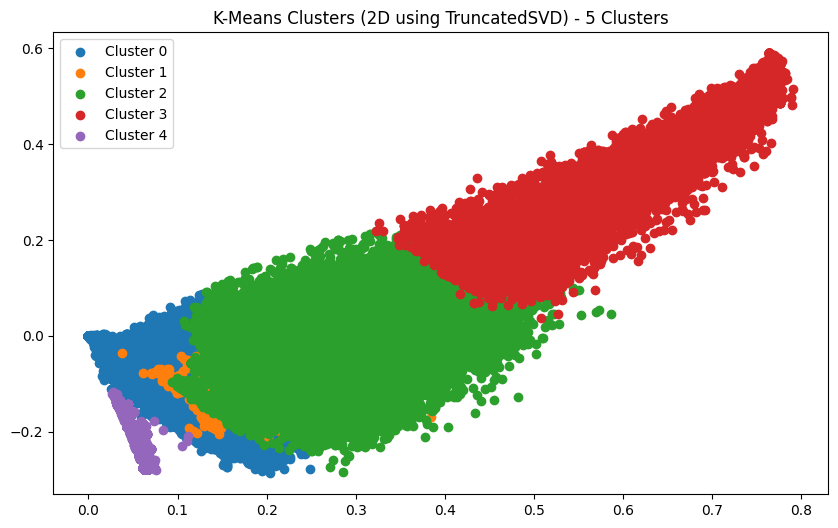

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Reduce to 2D
svd = TruncatedSVD(n_components=2)
X_2d = svd.fit_transform(X_tfidf)

# Plot with 5 clusters
plt.figure(figsize=(10, 6))
for cluster in range(5):  # 5 clusters
    plt.scatter(X_2d[email_data['Cluster'] == cluster, 0],
                X_2d[email_data['Cluster'] == cluster, 1],
                label=f'Cluster {cluster}')

plt.legend()
plt.title('K-Means Clusters (2D using TruncatedSVD) - 5 Clusters')
plt.show()

In [ ]:
terms = vectorizer.get_feature_names_out()

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("\n📌 **Top 10 Keywords Per Cluster:**")
for cluster_id in range(num_clusters):
    top_keywords = [terms[i] for i in order_centroids[cluster_id, :30]]
    print(f"Cluster {cluster_id}: {', '.join(top_keywords)}")


📌 **Top 10 Keywords Per Cluster:**
Cluster 0: enron, message, know, time, email, original, meeting, deal, pm, subject, need, gas, sent, new, let, report, power, day, attach, send, work, energy, question, change, week, like, want, image, today, price
Cluster 1: enron, perlingiere, debra, america, smith, north, street, texas, fax, houston, corp, phone, legal, employee, email, donate, department, consumer, company, fund, stock, energy, retirement, declare, urge, million, california, bankruptcy, lay, agreement
Cluster 2: email, subject, pm, cc, enron, message, forward, mail, request, original, send, recipient, corp, agreement, intend, know, vince, sent, mark, let, contract, information, need, receive, fax, kay, use, review, copy, sara
Cluster 3: email, pm, subject, cc, enron, mail, forward, david, mark, john, communications, jeff, meeting, fw, tana, mary, tom, message, eol, karen, scott, susan, richard, michael, james, robert, send, paul, mike, original
Cluster 4: hour, ahead, start, sche

In [ ]:
#predefined categories to clusters
category_mapping = {
    0: "General Discussion & Internal Updates",
    1: "Work & Office Communication",
    2: "IT Alerts & System Notifications",
    3: "Legal & Contractual Documents",
    4: "Spam & Security Warnings"
}

email_data['Cluster_Category'] = email_data['Cluster'].map(category_mapping)

In [ ]:
email_data['Cluster_Category'].value_counts()

,count
Cluster_Category,
General Discussion & Internal Updates,181077
IT Alerts & System Notifications,54505
Legal & Contractual Documents,9760
Work & Office Communication,4226
Spam & Security Warnings,3482


In [ ]:
random_emails = email_data.sample(n=10)  #10 random emails

for index, row in random_emails.iterrows():
    print("\n📌 **Random Email Selected:**")
    print(f"**Subject:** {row['Subject']}")
    print(f"**Message:** {row['Message']}")
    #print(f"**Conbined:** {row['Combined_Text']}")
    print(f"**Email Category:** {row['Cluster_Category']}")
    print("-" * 80)

K-Mean 5 Cluster - Inaccurate

In [ ]:
# Save the clustered dataset
#email_data.to_csv("clustered_emails_category.csv", index=False)
#files.download('clustered_emails_category.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Apply K-Means Clustering
num_clusters = 7  #Adjust based on dataset characteristics
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
email_data['Cluster_7'] = kmeans.fit_predict(X_tfidf)

#Display cluster distribution
print("Cluster distribution:\n", email_data['Cluster_7'].value_counts())

Cluster distribution:
 Cluster_7
5    151262
2     44034
1     33616
6      9968
0      9219
3      3482
4      1469
Name: count, dtype: int64


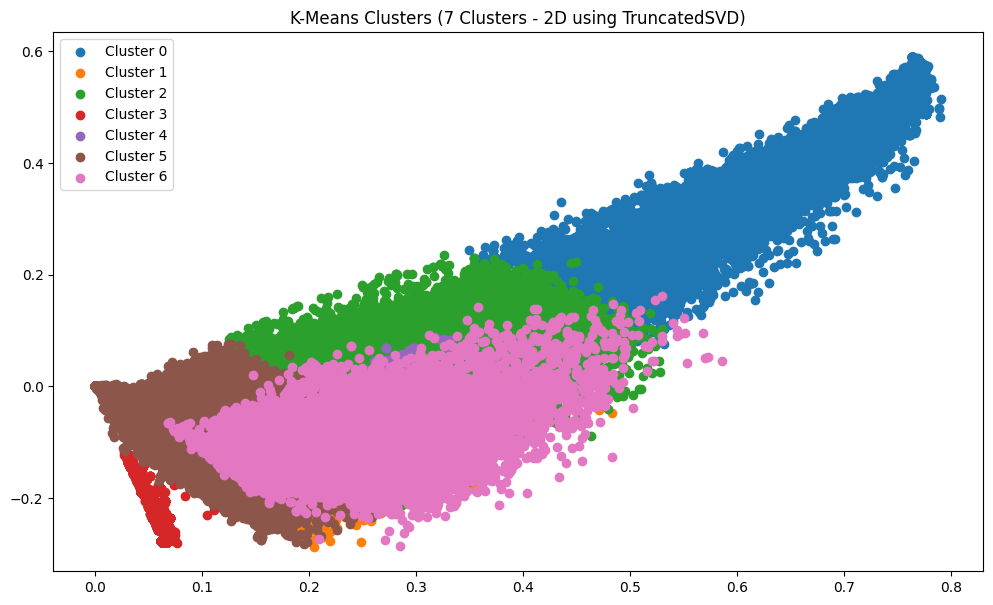

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Reduce to 2D
svd = TruncatedSVD(n_components=2)
X_2d = svd.fit_transform(X_tfidf)

# Plot with 5 clusters
plt.figure(figsize=(12, 7))
for cluster in range(num_clusters):  # range(7)
    plt.scatter(X_2d[email_data['Cluster_7'] == cluster, 0],
                X_2d[email_data['Cluster_7'] == cluster, 1],
                label=f'Cluster {cluster}')

plt.legend()
plt.title('K-Means Clusters (7 Clusters - 2D using TruncatedSVD)')
plt.show()

In [ ]:
terms = vectorizer.get_feature_names_out()

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("\n📌 **Top 10 Keywords Per Cluster:**")
for cluster_id in range(num_clusters):
    top_keywords = [terms[i] for i in order_centroids[cluster_id, :30]]
    print(f"Cluster {cluster_id}: {', '.join(top_keywords)}")


📌 **Top 10 Keywords Per Cluster:**
Cluster 0: email, pm, subject, cc, enron, mail, forward, david, mark, john, communications, jeff, fw, tana, mary, meeting, tom, message, eol, karen, scott, susan, michael, richard, robert, james, paul, original, send, mike
Cluster 1: original, message, sent, subject, pm, fw, october, email, november, monday, tuesday, wednesday, john, thursday, friday, know, mike, cc, january, let, need, send, michelle, meeting, mark, chris, attachmentpresent, enron, maggi, work
Cluster 2: email, cc, subject, pm, forward, enron, vince, agreement, know, send, mark, sara, deal, kay, let, need, corp, message, jeff, mail, fax, john, work, meeting, change, think, time, attach, want, like
Cluster 3: hour, ahead, start, schedule, final, variance, date, detect, parse, schedules, messages, ancillary, award, scheduling, portland, log, desk, west, california, file, codesite, transtype, mkttype, scid, transdate, preferred, crawler, tiepoint, engytype, interchgid
Cluster 4: reques

Cluster 0 - Internal Communication - General Discussion & Internal Updates

Cluster 1 - Forwarded Email Threads	- General Discussion & Internal Updates

Cluster 2 - Business Deals & Transactions	- Finance & Transaction

Cluster 3 - Internal Corporate Communication - General Discussion & Internal Updates


Cluster 4 - Legal & Regulatory - Legal & Contractual

Cluster 5 - IT & System Alerts	- IT Alerts & System Notifications

Cluster 6 - Meeting Coordination - Meeting & Scheduling

In [ ]:
#Apply K-Means Clustering
num_clusters = 15  #Adjust based on dataset characteristics
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
email_data['Cluster_15'] = kmeans.fit_predict(X_tfidf)

#Display cluster distribution
print("Cluster distribution:\n", email_data['Cluster_10'].value_counts())

Cluster distribution:
 Cluster_10
7    115765
9     41187
3     34298
8     32150
4      9046
1      6938
5      5040
2      3482
6      3348
0      1796
Name: count, dtype: int64


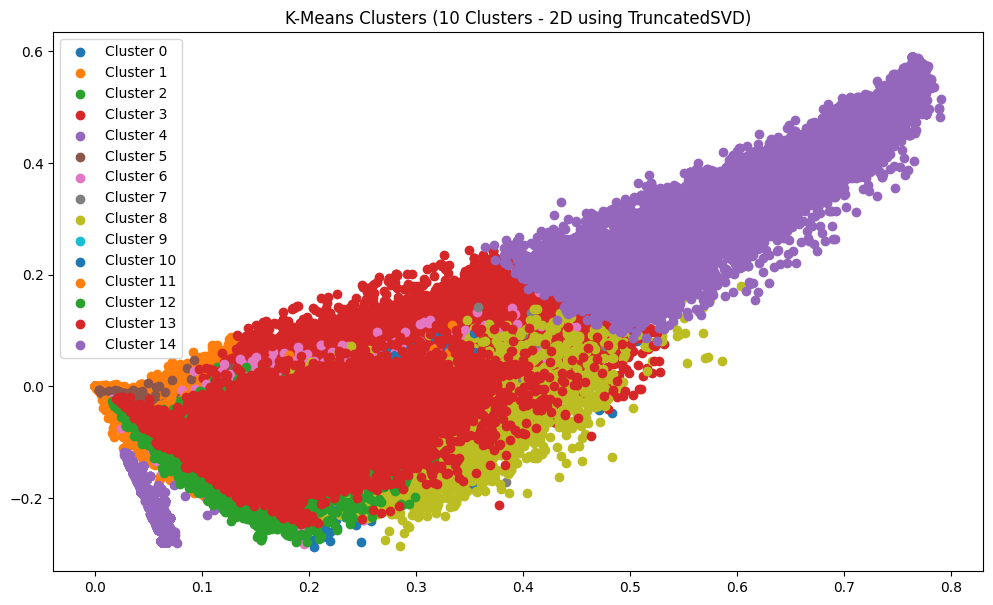

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Reduce to 2D
svd = TruncatedSVD(n_components=2)
X_2d = svd.fit_transform(X_tfidf)

# Plot with 5 clusters
plt.figure(figsize=(12, 7))
for cluster in range(num_clusters):  # range(7)
    plt.scatter(X_2d[email_data['Cluster_15'] == cluster, 0],
                X_2d[email_data['Cluster_15'] == cluster, 1],
                label=f'Cluster {cluster}')

plt.legend()
plt.title('K-Means Clusters (10 Clusters - 2D using TruncatedSVD)')
plt.show()

In [ ]:
terms = vectorizer.get_feature_names_out()

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("\n📌 **Top 10 Keywords Per Cluster:**")
for cluster_id in range(num_clusters):
    top_keywords = [terms[i] for i in order_centroids[cluster_id, :30]]
    print(f"Cluster {cluster_id}: {', '.join(top_keywords)}")


📌 **Top 10 Keywords Per Cluster:**
Cluster 0: description, chairperson, detailed, entry, time, calendar, central, standard, appointment, migration, outlook, date, team, mtg, pm, room, stacey, conference, white, lynn, staff, meeting, ebc, weekly, meet, invitation, office, reminder, vacation, buchanan
Cluster 1: recipient, intend, email, mail, message, use, confidential, contain, privileged, sender, corp, enron, affiliate, prohibit, delete, notify, copy, receive, distribution, information, strictly, intended, contract, attachment, disclosure, original, andor, reply, subject, error
Cluster 2: hour, ahead, start, schedule, final, variance, date, detect, parse, schedules, messages, ancillary, award, scheduling, portland, log, desk, west, california, file, codesite, transtype, mkttype, scid, transdate, preferred, crawler, tiepoint, engytype, interchgid
Cluster 3: gas, power, energy, market, price, enron, company, email, new, business, california, trading, report, contract, deal, year, servi

In [ ]:
cluster_labels = {
    0: "General Email Communication",
    1: "Email Forwarding & Follow-ups",
    2: "Business & Financial Discussions",
    3: "Corporate & Internal Emails",
    4: "Legal & Location-Based Documents",
    5: "IT & System Access Requests",
    6: "Scheduling & Time Management"
}

email_data['Cluster_7_Category'] = email_data['Cluster_7'].map(cluster_labels)

In [ ]:
email_data['Cluster_7_Category'].value_counts()

,count
Cluster_7_Category,
Business & Financial Discussions,149956
Corporate & Internal Emails,47489
Email Forwarding & Follow-ups,35204
General Email Communication,9351
IT & System Access Requests,3914
Legal & Location-Based Documents,3778
Scheduling & Time Management,3482


Refine K-Means Clustering by exploring sub-clusters


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

#Reinitialize vectorizer and dimensionality reduction
vectorizer = TfidfVectorizer(stop_words='english', max_features=8000)
svd = TruncatedSVD(n_components=100, random_state=42)

#Re-run the initial clustering to create the "Cluster" column
X_tfidf = vectorizer.fit_transform(email_data['Combined_Text'])
X_reduced = svd.fit_transform(X_tfidf)

num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
email_data['Cluster_7_Sub'] = kmeans.fit_predict(X_reduced)

#Extract Cluster 0 emails for separate reclustering
cluster_0_data = email_data[email_data['Cluster_7_Sub'] == 0]
X_cluster_0_tfidf = vectorizer.fit_transform(cluster_0_data['Combined_Text'])
X_cluster_0_reduced = svd.fit_transform(X_cluster_0_tfidf)

num_clusters_cluster_0 = 5  # Creating 5 sub-clusters for Cluster 0
kmeans_cluster_0 = KMeans(n_clusters=num_clusters_cluster_0, random_state=42, n_init=10)
cluster_0_data['Sub_Cluster'] = kmeans_cluster_0.fit_predict(X_cluster_0_reduced)

#Merge back the refined clustering results into the main dataset
email_data.loc[email_data['Cluster_7_Sub'] == 0, 'Sub_Cluster'] = cluster_0_data['Sub_Cluster']

#Assign NaN values in "Sub_Cluster" to their parent cluster
email_data['Sub_Cluster'] = email_data['Sub_Cluster'].fillna(email_data['Cluster_7_Sub'])

#Extract Cluster 6 emails for separate reclustering
cluster_6_data = email_data[email_data['Cluster_7_Sub'] == 6]
X_cluster_6_tfidf = vectorizer.fit_transform(cluster_6_data['Combined_Text'])
X_cluster_6_reduced = svd.fit_transform(X_cluster_6_tfidf)

num_clusters_cluster_6 = 5  #Creating 5 sub-clusters for Cluster 6
kmeans_cluster_6 = KMeans(n_clusters=num_clusters_cluster_6, random_state=42, n_init=10)
cluster_6_data['Sub_Cluster'] = kmeans_cluster_6.fit_predict(X_cluster_6_reduced)

#Merge refined sub-cluster results into the main dataset
email_data.loc[email_data['Cluster_7_Sub'] == 6, 'Sub_Cluster'] = cluster_6_data['Sub_Cluster']

<ipython-input-121-0128674765cc>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_0_data['Sub_Cluster'] = kmeans_cluster_0.fit_predict(X_cluster_0_reduced)
<ipython-input-121-0128674765cc>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_6_data['Sub_Cluster'] = kmeans_cluster_6.fit_predict(X_cluster_6_reduced)


In [ ]:
import numpy as np

terms = vectorizer.get_feature_names_out()

def get_top_keywords(model, terms, num_words=10):

    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    top_words_per_cluster = {
        cluster_id: [terms[i] for i in order_centroids[cluster_id, :num_words]]
        for cluster_id in range(model.n_clusters)
    }
    return top_words_per_cluster

top_keywords_main = get_top_keywords(kmeans, terms)
top_keywords_sub_0 = get_top_keywords(kmeans_cluster_0, terms)
top_keywords_sub_6 = get_top_keywords(kmeans_cluster_6, terms)

print("\n📌 **Top Keywords Per Cluster:**")
for cluster_id, words in top_keywords_main.items():
    print(f"Cluster {cluster_id}: {', '.join(words)}")

print("\n📌 **Top Keywords Per Sub-Cluster (Cluster 0):**")
for sub_cluster_id, words in top_keywords_sub_0.items():
    print(f"Sub-Cluster 0.{sub_cluster_id}: {', '.join(words)}")

print("\n📌 **Top Keywords Per Sub-Cluster (Cluster 6):**")
for sub_cluster_id, words in top_keywords_sub_6.items():
    print(f"Sub-Cluster 6.{sub_cluster_id}: {', '.join(words)}")


📌 **Top Keywords Per Cluster:**
Cluster 0: able, anne, alex, badlndplx, anita, assign, adjustment, carryover, balance, adam
Cluster 1: able, amt, adjustment, anguel, aeps, cc, bad, cancel, continue, calgenunit
Cluster 2: admin, adjust, aei, affect, able, ancillary, adjustment, alex, approve, anne
Cluster 3: able, adjust, additionally, adam, aeps, ancillary, beginning, ahead, arco, carbgnunit
Cluster 4: additionally, able, admin, ahead, aei, adjustment, anguel, bad, award, anne
Cluster 5: able, accept, act, anguel, arco, business, award, apx, bps, calgenunit
Cluster 6: act, able, additionally, bharati, adam, adjust, aei, admin, caps, alex

📌 **Top Keywords Per Sub-Cluster (Cluster 0):**
Sub-Cluster 0.0: additionally, able, aei, adjust, amt, ahead, ancillary, bert, aps, approve
Sub-Cluster 0.1: act, able, accept, additionally, adjustment, adjust, ahead, alex, approve, bennett
Sub-Cluster 0.2: able, accept, adjust, adjustment, aei, basically, calgenunit, assign, anita, apsepmiciso
Sub-Cl

In [ ]:
sub_cluster_labels = {
    3: "Product & Business Updates",
    1: "Internal Policies & Notices",
    0: "Financial & Legal Documents",
    4: "Official Communications & Drafts",
    2: "Outage & Scheduling Updates",
}

email_data['Sub_Cluster_Label'] = email_data['Sub_Cluster'].map(sub_cluster_labels)

In [ ]:
email_data['Sub_Cluster_Label'].value_counts()

,count
Sub_Cluster_Label,
Financial & Legal Documents,107010
Product & Business Updates,45574
Outage & Scheduling Updates,45404
Internal Policies & Notices,40577
Official Communications & Drafts,11136


In [ ]:
#TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_tfidf = vectorizer.fit_transform(email_data['Combined_Text'])

#Reduce dimensions using Truncated SVD (for efficiency)
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

#Apply K-Means Clustering with optimized number of clusters
num_clusters = 7  # Adjust the number of clusters if needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
email_data['Cluster'] = kmeans.fit_predict(X_reduced)

#Extract Cluster 0 emails for separate reclustering
cluster_0_data = email_data[email_data['Cluster'] == 0]

#Re-vectorize only Cluster 0 emails
X_cluster_0_tfidf = vectorizer.fit_transform(cluster_0_data['Combined_Text'])

#Reduce dimensions again for Cluster 0
X_cluster_0_reduced = svd.fit_transform(X_cluster_0_tfidf)

#Apply K-Means Clustering within Cluster 0
num_clusters_cluster_0 = 5  # Creating 5 sub-clusters for Cluster 0
kmeans_cluster_0 = KMeans(n_clusters=num_clusters_cluster_0, random_state=42, n_init=10)
cluster_0_data['Sub_Cluster'] = kmeans_cluster_0.fit_predict(X_cluster_0_reduced)

#Merge refined sub-cluster results into the main dataset
email_data.loc[email_data['Cluster'] == 0, 'Sub_Cluster'] = cluster_0_data['Sub_Cluster']

#Assign NaN values in "Sub_Cluster" to their parent cluster
email_data['Sub_Cluster'] = email_data['Sub_Cluster'].fillna(email_data['Cluster'])

#Extract Sub-Cluster 0 emails for **further refinement**
sub_cluster_0_data = email_data[email_data['Sub_Cluster'] == 0]

#Re-vectorize only Sub-Cluster 0 emails
X_sub_cluster_0_tfidf = vectorizer.fit_transform(sub_cluster_0_data['Combined_Text'])

#Reduce dimensions again for efficiency
X_sub_cluster_0_reduced = svd.fit_transform(X_sub_cluster_0_tfidf)

#Apply K-Means Clustering within **Sub-Cluster 0**
num_sub_clusters_0 = 5  # Creating 5 finer sub-clusters
kmeans_sub_cluster_0 = KMeans(n_clusters=num_sub_clusters_0, random_state=42, n_init=10)
sub_cluster_0_data['Finer_Sub_Cluster'] = kmeans_sub_cluster_0.fit_predict(X_sub_cluster_0_reduced)

#Merge refined finer sub-cluster results into the main dataset
email_data.loc[email_data['Sub_Cluster'] == 0, 'Finer_Sub_Cluster'] = sub_cluster_0_data['Finer_Sub_Cluster']

<ipython-input-108-b04876e98e13>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_0_data['Sub_Cluster'] = kmeans_cluster_0.fit_predict(X_cluster_0_reduced)
<ipython-input-108-b04876e98e13>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_cluster_0_data['Finer_Sub_Cluster'] = kmeans_sub_cluster_0.fit_predict(X_sub_cluster_0_reduced)


In [ ]:
finer_sub_cluster_distribution_0 = sub_cluster_0_data['Finer_Sub_Cluster'].value_counts()
print("\n📊 Finer Sub-Cluster distribution within Sub-Cluster 0:\n", finer_sub_cluster_distribution_0)


📊 Finer Sub-Cluster distribution within Sub-Cluster 0:
 Finer_Sub_Cluster
3    1780
1    1508
2     703
0     529
4      60
Name: count, dtype: int64


In [ ]:
sample_finer_sub_clusters_0 = sub_cluster_0_data.groupby('Finer_Sub_Cluster').head(5)[['Finer_Sub_Cluster', 'Cleaned_Subject', 'Cleaned_Message']]
print("\n📌 Sample Emails from Refined Finer Sub-Cluster 0:\n", sample_finer_sub_clusters_0)

In [ ]:
# Get the words corresponding to each feature index
terms = vectorizer.get_feature_names_out()

# Function to get top words per cluster
def get_top_keywords(model, terms, num_words=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    return {
        cluster_id: [terms[i] for i in order_centroids[cluster_id, :num_words]]
        for cluster_id in range(model.n_clusters)
    }

top_keywords_main = get_top_keywords(kmeans, terms)

top_keywords_sub_0 = get_top_keywords(kmeans_cluster_0, terms)

top_keywords_finer_sub_0 = get_top_keywords(kmeans_sub_cluster_0, terms)

print("\n📌 **Top Keywords Per Main Cluster:**")
for cluster_id, words in top_keywords_main.items():
    print(f"Cluster {cluster_id}: {', '.join(words)}")

print("\n📌 **Top Keywords Per Sub-Cluster (Cluster 0):**")
for sub_cluster_id, words in top_keywords_sub_0.items():
    print(f"Sub-Cluster 0.{sub_cluster_id}: {', '.join(words)}")

print("\n📌 **Top Keywords Per Finer Sub-Cluster (Sub-Cluster 0):**")
for finer_sub_cluster_id, words in top_keywords_finer_sub_0.items():
    print(f"Finer Sub-Cluster 0.{finer_sub_cluster_id}: {', '.join(words)}")


📌 **Top Keywords Per Main Cluster:**
Cluster 0: ability, abstract, academy, accordingly, actual, accord, accommodate, achieve, additionally, act
Cluster 1: acceptable, accommodate, accomplishment, ability, accurate, adam, accordingly, accounting, accomplish, adaptive
Cluster 2: ability, absolutely, acceptable, acceptance, accept, accomplishment, accounting, academy, adapt, allen
Cluster 3: ability, able, absence, acquire, accomplishment, addition, acceptance, acceptable, advanced, adjust
Cluster 4: ability, academic, academy, accomplish, actively, academe, addition, action, actually, accomplishment
Cluster 5: ability, academe, abstract, absolutely, accomodate, access, adam, administration, add, accurate
Cluster 6: absence, abstract, ability, absolutely, acceptable, accept, activity, action, adapt, accommodate

📌 **Top Keywords Per Sub-Cluster (Cluster 0):**
Sub-Cluster 0.0: ability, absence, absolutely, academe, abstract, accomodate, acceptance, accordingly, adaptive, achieve
Sub-Clus

In [ ]:
# Define words to remove (based on high frequency in all clusters)
common_words = {"ability", "acceptable", "abstract", "academic", "accomplish", "access",
                "act", "accounting", "accordingly", "academy", "adaptive"}

# Function to remove generic words from top words list
def clean_keywords(word_list):
    return [word for word in word_list if word not in common_words]

# Apply cleaning to clusters
filtered_clusters = {cluster_id: clean_keywords(words) for cluster_id, words in top_keywords_main.items()}
filtered_sub_clusters_0 = {cluster_id: clean_keywords(words) for cluster_id, words in top_keywords_sub_0.items()}
filtered_finer_sub_clusters_0 = {cluster_id: clean_keywords(words) for cluster_id, words in top_keywords_finer_sub_0.items()}

# Print cleaned keywords
print("\n📌 **Top Keywords After Cleaning:**")
for cluster_id, words in filtered_clusters.items():
    print(f"Cluster {cluster_id}: {', '.join(words)}")

print("\n📌 **Top Keywords After Cleaning (Sub-Cluster 0):**")
for sub_cluster_id, words in filtered_sub_clusters_0.items():
    print(f"Sub-Cluster 0.{sub_cluster_id}: {', '.join(words)}")

print("\n📌 **Top Keywords After Cleaning (Finer Sub-Cluster 0):**")
for finer_sub_cluster_id, words in filtered_finer_sub_clusters_0.items():
    print(f"Finer Sub-Cluster 0.{finer_sub_cluster_id}: {', '.join(words)}")


📌 **Top Keywords After Cleaning:**
Cluster 0: actual, accord, accommodate, achieve, additionally
Cluster 1: accommodate, accomplishment, accurate, adam
Cluster 2: absolutely, acceptance, accept, accomplishment, adapt, allen
Cluster 3: able, absence, acquire, accomplishment, addition, acceptance, advanced, adjust
Cluster 4: actively, academe, addition, action, actually, accomplishment
Cluster 5: academe, absolutely, accomodate, adam, administration, add, accurate
Cluster 6: absence, absolutely, accept, activity, action, adapt, accommodate

📌 **Top Keywords After Cleaning (Sub-Cluster 0):**
Sub-Cluster 0.0: absence, absolutely, academe, accomodate, acceptance, achieve
Sub-Cluster 0.1: able, absence, accurate, activity, academe
Sub-Cluster 0.2: absolutely, able, accomodate, acceptance, accord, adedeji
Sub-Cluster 0.3: absence, accord, accomplishment, ad, administrator, acquire, additional
Sub-Cluster 0.4: academe, accommodate, accept, accomodate, add

📌 **Top Keywords After Cleaning (Fin

In [ ]:
import numpy as np
#Extract **Finer Sub-Cluster 0** emails for further breakdown
finer_sub_cluster_0_data = email_data[email_data['Finer_Sub_Cluster'] == 0]

#Apply TF-IDF Vectorization on **Finer Sub-Cluster 0**
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_finer_sub_cluster_0_tfidf = vectorizer.fit_transform(finer_sub_cluster_0_data['Combined_Text'])

#Reduce dimensions using Truncated SVD for efficiency
svd = TruncatedSVD(n_components=100, random_state=42)
X_finer_sub_cluster_0_reduced = svd.fit_transform(X_finer_sub_cluster_0_tfidf)

#Apply K-Means Clustering to **further break down Finer Sub-Cluster 0**
num_finer_sub_clusters_0 = 5  # Creating 5 additional sub-clusters
kmeans_finer_sub_cluster_0 = KMeans(n_clusters=num_finer_sub_clusters_0, random_state=42, n_init=10)
finer_sub_cluster_0_data['Granular_Sub_Cluster'] = kmeans_finer_sub_cluster_0.fit_predict(X_finer_sub_cluster_0_reduced)

#Merge refined finer sub-cluster results into the main dataset
email_data.loc[email_data['Finer_Sub_Cluster'] == 0, 'Granular_Sub_Cluster'] = finer_sub_cluster_0_data['Granular_Sub_Cluster']

#Extract Keywords from each cluster
def get_top_keywords(tfidf_matrix, terms, num_words=10):
    """Extract top words per cluster"""
    top_keywords = []
    for i in range(num_finer_sub_clusters_0):
        mean_tfidf = np.mean(tfidf_matrix[kmeans_finer_sub_cluster_0.labels_ == i], axis=0)
        sorted_indices = np.argsort(mean_tfidf)[::-1][:num_words]
        keywords = [terms[j] for j in sorted_indices]
        top_keywords.append((i, keywords))
    return top_keywords

#Get top terms per cluster
terms = vectorizer.get_feature_names_out()
top_keywords_per_cluster = get_top_keywords(X_finer_sub_cluster_0_tfidf.toarray(), terms)

<ipython-input-12-d9a43eae6803>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finer_sub_cluster_0_data['Granular_Sub_Cluster'] = kmeans_finer_sub_cluster_0.fit_predict(X_finer_sub_cluster_0_reduced)


In [ ]:
#Display Keywords per new finer sub-cluster
print("\n📌 **Top Keywords Per Granular Sub-Cluster:**")
for cluster_id, keywords in top_keywords_per_cluster:
    print(f"Cluster {cluster_id}: {', '.join(keywords)}")


📌 **Top Keywords Per Granular Sub-Cluster:**
Cluster 0: know, let, think, want, work, good, time, like, week, look
Cluster 1: agreement, attach, draft, letter, comment, review, document, copy, change, form
Cluster 2: dbcapsdata, database, alias, unknown, closed, operation, perform, error, hourahead, schedule
Cluster 3: enron, pm, need, office, email, question, new, file, number, today
Cluster 4: email, mail, click, free, information, receive, new, message, password, send


In [ ]:
#Display refined granular sub-cluster distribution
granular_sub_cluster_distribution_0 = finer_sub_cluster_0_data['Granular_Sub_Cluster'].value_counts()
print("\n📊 Granular Sub-Cluster distribution within **Finer Sub-Cluster 0**:\n", granular_sub_cluster_distribution_0)


📊 Granular Sub-Cluster distribution within **Finer Sub-Cluster 0**:
 Granular_Sub_Cluster
3    51615
0    19492
4    14564
1     9835
2      339
Name: count, dtype: int64


In [ ]:
#Show sample emails from refined Granular Sub-Clusters
sample_granular_sub_clusters_0 = finer_sub_cluster_0_data.groupby('Granular_Sub_Cluster').head(5)[['Granular_Sub_Cluster', 'Cleaned_Subject', 'Cleaned_Message']]
print("\n📌 Sample Emails from **Granular Sub-Cluster 0**:\n", sample_granular_sub_clusters_0)

#NER + K-Mean

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

#Step 1: Convert Named_Entities into Entity Count Features
def count_entity_types(entities):
    """ Robustly count common entity types from Named_Entities column """
    entity_counts = {"PERSON": 0, "ORG": 0, "DATE": 0, "MONEY": 0, "GPE": 0}

    if not isinstance(entities, list):
        return pd.Series(entity_counts)

    for ent in entities:
        if isinstance(ent, tuple) and len(ent) == 2:
            text, label = ent
            if label in entity_counts:
                entity_counts[label] += 1

    return pd.Series(entity_counts)

ner_features = email_data['Named_Entities'].apply(count_entity_types)

email_data['Combined_Text'] = email_data['Combined_Text'].fillna("")

#Step 2: TF-IDF Vectorization of Combined_Text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # You can tune max_features if needed
tfidf_vectors = vectorizer.fit_transform(email_data['Combined_Text'])

#Step 3: Combine TF-IDF + NER Counts into Full Feature Set
ner_matrix = np.array(ner_features)  # Convert to numpy array (NER count features)
full_feature_matrix = hstack([tfidf_vectors, ner_matrix])  # Combine sparse + dense

#Step 4: Determine Optimal K (Optional Step - Elbow Method or Silhouette)
def find_best_k():
    scores = []
    k_range = range(2, 15)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(full_feature_matrix)
        score = silhouette_score(full_feature_matrix, labels)
        scores.append(score)

    plt.plot(k_range, scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Optimal K Selection')
    plt.show()

#Run this once to find the best k for your data
find_best_k()

#Step 5: Train Final K-Means (Adjust K after finding best value)
best_k = 8  # Adjust this after seeing your elbow plot or silhouette score
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
email_data['Cluster_N_K'] = kmeans.fit_predict(full_feature_matrix)

# Step 6: Map Clusters to Categories (Manual Mapping after Review)
# After clustering, you review some samples from each cluster and assign a category name.
cluster_to_category = {
    0: 'Finance & Transaction',
    1: 'Legal & Contractual',
    2: 'Spam',
    3: 'Promotion',
    4: 'IT Alerts & System Notifications',
    5: 'Meeting & Scheduling',
    6: 'General Discussion & Internal Updates',
    7: 'Business Communication'
}

email_data['NER_KMeans_Category'] = email_data['Cluster_N_K'].map(cluster_to_category)

#Compare Rule-based and K-Means Categories (if you still have NER_Category)
if 'NER_Category' in email_data.columns:
    comparison = email_data[['NER_Category', 'NER_KMeans_Category']].value_counts()
    print("\nComparison between Rule-based and KMeans+NER Categories:")
    print(comparison)

print(email_data[['Subject', 'NER_Category', 'NER_KMeans_Category']].head(20))

#Keyword Based

In [ ]:
import pandas as pd

def refine_labels(row):
    subject = str(row['Cleaned_Subject']).lower() if pd.notna(row['Cleaned_Subject']) else ''
    message = str(row['Cleaned_Message']).lower() if pd.notna(row['Cleaned_Message']) else ''

    categories = {
        "Spam & Security Warnings": [
            "virus", "warning", "spam", "unsubscribe", "risk", "malware", "scam", "alert", "fraud",
            "promotion", "limited offer", "click here", "remove me", "phishing", "security update",
            "free trial", "exclusive offer", "guaranteed", "urgent", "free gift", "winner", "claim your prize",
            "payment required", "congratulations", "act now", "reminder", "unlock", "satisfaction guaranteed",
            "subscription", "unsubscribed", "click below", "download now", "offer expires", "this is not spam"
        ],
        "IT Alerts & System Notifications": [
            "system error", "server down", "database issue", "system failure", "network outage",
            "connectivity issue", "downtime", "performance alert", "IT alert", "security breach",
            "firewall", "patch update", "critical update", "reboot required", "incident report",
            "high CPU usage", "memory leak detected", "disk space low", "scheduled maintenance"
        ],
        "Legal & Contractual Documents": [
            "agreement", "contract", "terms", "nda", "disclosure", "compliance", "legal", "requirement",
            "policy update", "regulatory compliance", "lawsuit", "litigation", "settlement", "court",
            "dispute", "arbitration", "confidentiality agreement", "binding agreement", "trade agreement",
            "legal notice", "warranty", "terms and conditions", "indemnity"
        ],
        "Work & Office Communication": [
            "meeting", "report", "update", "discussion", "project", "task", "assignment", "proposal",
            "attachment", "client request", "internal coordination", "performance report", "work progress",
            "team update", "agenda", "minutes", "follow-up", "status update", "client feedback",
            "deadline", "timeline", "presentation", "workshop", "training session"
        ]
    }

    for category, keywords in categories.items():
        if any(word in subject or word in message for word in keywords):
            return category

    return row["Email_Category"] if pd.notna(row["Email_Category"]) else "General Discussion & Internal Updates"

# Ensure 'Email_Category' exists
if 'Email_Category' not in email_data.columns:
    email_data['Email_Category'] = None

# Apply refined labels efficiently
email_data['Email_Category'] = email_data.apply(refine_labels, axis=1)

In [ ]:
email_data['Email_Category'].value_counts()

,count
Email_Category,
General Discussion & Internal Updates,93784
Legal & Contractual Documents,90974
Work & Office Communication,36351
Spam & Security Warnings,31800
IT Alerts & System Notifications,265


In [ ]:
random_emails = email_data.sample(n=10)  #10 random emails

for index, row in random_emails.iterrows():
    print("\n📌 **Random Email Selected:**")
    print(f"**From:** {row['From']}")
    print(f"**To:** {row['To']}")
    print(f"**Subject:** {row['Subject']}")
    print(f"**Message:** {row['Message']}")
    print(f"**Email Category:** {row['Email_Category']}")
    print("-" * 80)

In [ ]:
#from google.colab import files

#email_data.to_csv('email_cluster_category.csv', index=False)

#Download the file
#files.download('email_cluster_category.csv')

#Other Method Pre-Trained Model

Load again for LLMA

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

email_data = pd.read_csv('/content/drive/MyDrive/FYPDataset/emails_LDA_NER_category.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
email_data.columns

Index(['From', 'To', 'Subject', 'Message', 'Day', 'Cleaned_Message',
       'Cleaned_Subject', 'Combined_Text', 'Topic', 'LDA_Topic',
       'LDA_Category', 'Original_Combined_Text', 'Named_Entities'],
      dtype='object')

In [ ]:
email_data

In [ ]:
email_data = email_data.drop(columns=["LDA_Topic"])
email_data = email_data.drop(columns=["Named_Entities"])
email_data = email_data.drop(columns=["Topic"])
email_data = email_data.drop(columns=["Original_Combined_Text"])
email_data = email_data.drop(columns=["LDA_Category"])

In [ ]:
import re
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'([!@#$_-])\1{2,}', r'\1', text)  # Remove excessive symbols
    text = re.sub(r'\n\s*\n', '\n', text)  # Remove excessive newlines
    return text.strip()

email_data['Cleaned_Subject'] = email_data['Subject'].apply(clean_text)
email_data['Cleaned_Message'] = email_data['Message'].apply(clean_text)

In [ ]:
email_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253174 entries, 0 to 253173
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   From             253174 non-null  object
 1   To               243284 non-null  object
 2   Subject          244468 non-null  object
 3   Message          253174 non-null  object
 4   Day              253174 non-null  object
 5   Cleaned_Message  253174 non-null  object
 6   Cleaned_Subject  253174 non-null  object
 7   Combined_Text    252718 non-null  object
dtypes: object(8)
memory usage: 15.5+ MB


In [ ]:
from google.colab import files

email_data.to_csv('email_data_with_ml_labels.csv', index=False)

files.download('email_data_with_ml_labels.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Mini LLM

In [ ]:
email_data['ML_Category'] = pd.NA

In [ ]:
email_data

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to dataset
checkpoint_file_path = '/content/drive/MyDrive/FYPDataset/email_data_with_ml_labels.csv'

# Load the dataset
email_data = pd.read_csv(checkpoint_file_path)

# Ensure critical columns always exist
if 'ML_Category' not in email_data.columns:
    email_data['ML_Category'] = None

# Save back immediately to lock in structure
email_data.to_csv(checkpoint_file_path, index=False)

# Combine subject and message into a single text block
email_data['Combined_Text_2'] = email_data.apply(
    lambda x: f"Subject: {x['Cleaned_Subject']}\nMessage: {x['Cleaned_Message']}"
              if pd.notna(x['Cleaned_Subject']) else x['Cleaned_Message'],
    axis=1
)

# Define categories
categories = [
    "Finance & Transaction",
    "Legal & Contractual",
    "Spam",
    "Promotion",
    "IT Alerts & System Notifications",
    "Meeting & Scheduling",
    "General Discussion & Internal Updates",
    "Business Communication"
]

# Load SentenceTransformer Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Precompute category embeddings (these don't change per batch)
category_embeddings = model.encode(categories, normalize_embeddings=True)

# Batch size (adjustable)
BATCH_SIZE = 50

# Process in batches (and skip already processed rows)
for start_idx in range(0, len(email_data), BATCH_SIZE):
    end_idx = min(start_idx + BATCH_SIZE, len(email_data))

    # Skip batch if all rows already have ML_Category filled
    if email_data.iloc[start_idx:end_idx]['ML_Category'].notna().all():
        print(f"✅ Batch {start_idx} to {end_idx} already processed. Skipping.")
        continue

    print(f"🔄 Processing batch {start_idx} to {end_idx}")

    # Get batch text and compute embeddings
    batch_texts = email_data.iloc[start_idx:end_idx]['Combined_Text_2'].tolist()
    batch_embeddings = model.encode(batch_texts, normalize_embeddings=True)

    # Compute similarity and predict categories
    similarities = util.cos_sim(batch_embeddings, category_embeddings)
    predicted_indices = similarities.argmax(dim=1).tolist()
    predicted_categories = [categories[i] for i in predicted_indices]

    # Assign predicted categories to the batch
    email_data.iloc[start_idx:end_idx, email_data.columns.get_loc('ML_Category')] = predicted_categories

    # ✅ Save checkpoint after every batch
    email_data.to_csv(checkpoint_file_path, index=False)
    print(f"✅ Saved checkpoint at batch {start_idx} to {end_idx}")

print(f"✅ Full classification process complete! Final results saved to: {checkpoint_file_path}")

Facebook

In [ ]:
import pandas as pd
from transformers import pipeline

# Load your dataset
checkpoint_file_path = '/content/drive/MyDrive/FYPDataset/email_data_with_gpt_labels.csv'

# Add Category column if not present
if 'ML_Category' not in email_data.columns:
    email_data['ML_Category'] = None

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define your 8 categories
categories = [
    "Finance & Transaction",
    "Legal & Contractual",
    "Spam",
    "Promotion",
    "IT Alerts & System Notifications",
    "Meeting & Scheduling",
    "General Discussion & Internal Updates",
    "Business Communication"
]

# Classification function
def classify_email(subject, message):
    combined_text = f"Subject: {subject}\nMessage: {message}"
    result = classifier(combined_text, candidate_labels=categories)
    return result['labels'][0]  # Top predicted category

# Process all emails
for idx, row in email_data.iterrows():
    if pd.isna(email_data.at[idx, 'ML_Category']):
        subject = row['Subject'] if pd.notna(row['Subject']) else ""
        message = row['Message'] if pd.notna(row['Message']) else ""

        predicted_category = classify_email(subject, message)
        email_data.at[idx, 'ML_Category'] = predicted_category

        # Save after each row (acts like a checkpoint)
        email_data.to_csv(checkpoint_file_path, index=False)

print(f"✅ Classification complete! Results saved to: {checkpoint_file_path}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


In [ ]:
email_data['ML_Category'].value_counts()

,count
ML_Category,
,253174


In [ ]:
import pandas as pd
from transformers import pipeline
from google.colab import drive
drive.mount('/content/drive')

# Load dataset again
checkpoint_file_path = '/content/drive/MyDrive/FYPDataset/email_data_with_gpt_labels.csv'
email_data = pd.read_csv(checkpoint_file_path)

# Ensure 'ML_Category' column exists
if 'ML_Category' not in email_data.columns:
    email_data['ML_Category'] = None

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define categories
categories = [
    "Finance & Transaction",
    "Legal & Contractual",
    "Spam",
    "Promotion",
    "IT Alerts & System Notifications",
    "Meeting & Scheduling",
    "General Discussion & Internal Updates",
    "Business Communication"
]

# Classification function
def classify_email(subject, message):
    combined_text = f"Subject: {subject}\nMessage: {message}"
    result = classifier(combined_text, candidate_labels=categories)
    return result['labels'][0]  # Top predicted category

# Process only unclassified emails
for idx, row in email_data[email_data['ML_Category'].isna()].iterrows():
    subject = row['Subject'] if pd.notna(row['Subject']) else ""
    message = row['Message'] if pd.notna(row['Message']) else ""

    predicted_category = classify_email(subject, message)
    email_data.at[idx, 'ML_Category'] = predicted_category

    # Save after processing each row (acts as a checkpoint)
    email_data.to_csv(checkpoint_file_path, index=False)

print(f"✅ Classification resumed and completed! Results saved to: {checkpoint_file_path}")

In [ ]:
import pandas as pd
from transformers import pipeline
from google.colab import drive

drive.mount('/content/drive')

checkpoint_file_path = '/content/drive/MyDrive/FYPDataset/email_data_with_gpt_labels.csv'

email_data = pd.read_csv(checkpoint_file_path)

#Add ML_Category column if missing
if 'ML_Category' not in email_data.columns:
    email_data['ML_Category'] = None

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

categories = [
    "Finance & Transaction",
    "Legal & Contractual",
    "Spam",
    "Promotion",
    "IT Alerts & System Notifications",
    "Meeting & Scheduling",
    "General Discussion & Internal Updates",
    "Business Communication"
]

#Filter only unclassified AND non-empty emails
unclassified_emails = email_data[
    email_data['ML_Category'].isna() &
    (email_data['Subject'].notna() | email_data['Message'].notna())
].copy()

#Processing in Batches
batch_size = 50
save_every_batches = 2  # Save after every 2 batches (adjustable for safety vs speed)

for batch_index, start in enumerate(range(0, len(unclassified_emails), batch_size)):
    batch = unclassified_emails.iloc[start:start + batch_size]

    combined_texts = [
        f"Subject: {row['Subject']}\nMessage: {row['Message']}"
        if pd.notna(row['Subject']) else
        f"Message: {row['Message']}"
        for _, row in batch.iterrows()
    ]

    results = classifier(combined_texts, candidate_labels=categories)

    #Update email_data with predicted categories
    for i, (idx, row) in enumerate(batch.iterrows()):
        predicted_category = results[i]['labels'][0]
        email_data.at[idx, 'ML_Category'] = predicted_category

    #Save every N batches
    if (batch_index + 1) % save_every_batches == 0:
        email_data.to_csv(checkpoint_file_path, index=False)

#Final save at the end (catch anything unsaved)
email_data.to_csv(checkpoint_file_path, index=False)

print(f"✅ Batch classification completed and saved to: {checkpoint_file_path}")

#DeepSeek

In [ ]:
email_data['ML_Category'].value_counts()